# **Proyek Analisis Sentimen: Ulasan Aplikasi Tokopedia**

- **Nama:** Muhammad Husain Fadhlillah
- **Email Student:** mc006d5y2343@student.devacademy.id
- **Cohort ID:** MC006D5Y2343

## **1. Persiapan Awal**

### 1.1 Instalasi Library

In [1]:
# Menginstal library yang diperlukan untuk pemrosesan teks, pemodelan, dan visualisasi
!pip install emoji Sastrawi wordcloud xgboost transformers matplotlib seaborn tqdm gensim -q

* **Metode yang digunakan** → Metode yang digunakan adalah **instalasi paket (*batch installation*)** dari serangkaian *library* Python yang esensial untuk tahap-tahap selanjutnya. Berbagai *library* dengan fungsi yang berbeda diinstal dalam satu perintah tunggal untuk mempersiapkan lingkungan kerja secara komprehensif.

* **Alasan penggunaan** → Instalasi ini bersifat strategis, di mana setiap *library* dipilih untuk memainkan peran spesifik dalam alur kerja proyek, mulai dari pra-pemrosesan hingga evaluasi model, dan secara langsung mendukung pencapaian kriteria Bintang 5:
    * **Untuk Pra-pemrosesan Teks:**
        * `Sastrawi`: *Library* fundamental untuk NLP Bahasa Indonesia. Akan digunakan untuk *stemming* (mengubah kata menjadi bentuk dasar, misal: "memainkan" → "main") dan penghapusan *stopword* (kata umum seperti "dan", "di", "yang"). Ini krusial untuk mereduksi *noise* dan menstandarisasi fitur teks.
        * `emoji`: Ulasan pengguna sering kali mengandung emoji yang kaya akan sentimen (misal: 👍, 😠). *Library* ini akan digunakan untuk menerjemahkan emoji menjadi representasi teks agar maknanya dapat ditangkap oleh model.
    * **Untuk Eksperimen Pemodelan & Ekstraksi Fitur:**
        * `xgboost`: Pilihan algoritma *machine learning* klasik yang sangat kuat (berbasis *Gradient Boosting*). Akan digunakan sebagai salah satu dari **tiga skema percobaan** model.
        * `gensim`: Akan digunakan untuk implementasi `Word2Vec`, sebuah teknik *word embedding* yang canggih untuk mengubah kata menjadi vektor numerik. Ini akan menjadi salah satu metode **ekstraksi fitur** yang diuji.
        * `transformers`: Ini adalah *library* kunci untuk memenuhi syarat **penggunaan Deep Learning**. Dengan `transformers` dari Hugging Face, kita dapat mengimplementasikan model canggih seperti IndoBERT, yang merupakan *state-of-the-art* untuk pemahaman teks Bahasa Indonesia dan menjadi kandidat utama untuk mencapai **akurasi di atas 92%**.
    * **Untuk Visualisasi & Utilitas:**
        * `matplotlib` & `seaborn`: Kombinasi standar untuk membuat visualisasi data, seperti diagram batang untuk distribusi sentimen, grafik riwayat pelatihan model, dan *heatmap* untuk *confusion matrix*.
        * `wordcloud`: Digunakan untuk membuat visualisasi *word cloud*, sebuah cara intuitif untuk menampilkan kata-kata yang paling sering muncul pada setiap kategori sentimen saat tahap eksplorasi data.
        * `tqdm`: Menyediakan *progress bar* yang informatif, sangat berguna untuk memantau proses yang memakan waktu lama seperti pra-pemrosesan pada 15.000 data atau pelatihan model Deep Learning.

* **Insight dan Hasil yang didapat** → *Output* `(berhasil install)` mengonfirmasi bahwa seluruh perangkat lunak yang diperlukan untuk tahap analisis inti telah berhasil ditambahkan ke lingkungan kerja. **Insight utamanya adalah bahwa proyek ini sekarang secara teknis telah siap untuk melakukan analisis menyeluruh.**

### 1.2 Import Library

In [2]:
# Untuk mengabaikan peringatan yang tidak relevan agar output lebih bersih
import warnings
warnings.filterwarnings('ignore')

# Import library umum untuk manipulasi data dan komputasi
import pandas as pd
import numpy as np
import re
import string
import emoji

# Import library untuk visualisasi data
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Import library untuk pra-pemrosesan teks (NLP)
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)

# Import library untuk ekstraksi fitur
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec

# Import library untuk pemodelan machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Import library untuk pelabelan dan tqdm untuk progress bar
from transformers import pipeline
from tqdm.auto import tqdm
tqdm.pandas()

# Import library untuk menyeimbangkan data
from sklearn.utils import resample

# Import library untuk menyimpan dan memuat model
import joblib

print("Semua library berhasil diimpor.")

Semua library berhasil diimpor.


* **Metode yang digunakan** → Tahap ini menerapkan **impor *library* secara terstruktur dan komprehensif**, di mana seluruh "perkakas" yang dibutuhkan untuk siklus hidup proyek—mulai dari pembersihan data hingga penyimpanan model—dimuat sekaligus. *Library* yang diimpor dikelompokkan secara logis berdasarkan fungsinya.

* **Alasan penggunaan** → Blok kode ini berfungsi sebagai *blueprint* teknis untuk keseluruhan proyek. Setiap kelompok *library* diimpor dengan tujuan yang sangat spesifik dan kritis, yang secara kolektif memastikan semua kriteria proyek dapat terpenuhi:

    1.  **Dasar & Manipulasi Data** (`pandas`, `numpy`, `re`, `string`, `emoji`): Ini adalah fondasi. `pandas` dan `numpy` untuk mengelola `DataFrame`, sementara `re` (Regular Expressions), `string`, dan `emoji` adalah perangkat esensial untuk tahap awal pembersihan teks (menghapus URL, angka, tanda baca, dan menangani emoji).

    2.  **Visualisasi Data** (`matplotlib`, `seaborn`, `WordCloud`): Diperlukan untuk *Exploratory Data Analysis* (EDA) dan presentasi hasil. Akan digunakan untuk memvisualisasikan distribusi sentimen, frekuensi kata (*WordCloud*), dan metrik performa model (*confusion matrix*).

    3.  **Pra-pemrosesan Teks (NLP)** (`nltk`, `Sastrawi`): Ini adalah inti dari pipeline pemrosesan teks Bahasa Indonesia. `nltk` digunakan untuk *tokenization* (memecah kalimat menjadi kata), sementara `Sastrawi` digunakan untuk *stemming* (mengubah kata ke bentuk dasarnya). Kombinasi ini penting untuk mengurangi kompleksitas kosakata dan membantu model dalam generalisasi.

    4.  **Ekstraksi Fitur** (`TfidfVectorizer`, `gensim.models.Word2Vec`): Pemilihan ini secara langsung mendukung **kriteria 3 skema percobaan**.
        * `TfidfVectorizer`: Akan digunakan untuk mengubah teks menjadi representasi numerik berbasis frekuensi kata (TF-IDF). Ini adalah metode *baseline* yang kuat.
        * `Word2Vec` (`gensim`): Akan digunakan untuk menciptakan *word embedding*, di mana kata direpresentasikan sebagai vektor padat yang menangkap makna semantik. Ini adalah metode ekstraksi fitur yang lebih canggih.

    5.  **Pemodelan, Evaluasi & Balancing:**
        * **Algoritma** (`RandomForest`, `XGBClassifier`, `LogisticRegression`, `transformers`): Menyediakan beragam algoritma untuk dibandingkan—dari model linear sederhana hingga *ensemble* yang kompleks dan **model Deep Learning** (`transformers`) untuk memenuhi syarat Bintang 5.
        * **Utilitas Model** (`train_test_split`, `LabelEncoder`, `metrics`): Alat standar `scikit-learn` untuk membagi data, mengubah label kategorikal menjadi angka, dan mengevaluasi performa model secara kuantitatif.
        * **Penyeimbangan Data** (`resample`): Ini adalah impor yang **sangat kritis**. Ini menunjukkan kesadaran bahwa dataset ulasan di dunia nyata sering kali **tidak seimbang** (misalnya, lebih banyak ulasan positif). Adanya `resample` menandakan adanya rencana untuk mengatasi masalah ini (misal dengan *oversampling* atau *undersampling*), yang merupakan praktik terbaik untuk membangun model yang adil dan akurat.

    6.  **Penyimpanan Model** (`joblib`): Digunakan untuk menyimpan model terbaik yang telah dilatih. Ini adalah praktik rekayasa perangkat lunak yang baik, memungkinkan model untuk digunakan kembali di masa depan tanpa perlu melatih ulang.

* **Insight dan Hasil yang didapat** → *Output* `Semua library berhasil diimpor.` adalah konfirmasi sederhana namun krusial bahwa seluruh ekosistem teknis untuk proyek ini telah siap dan bebas dari konflik.

## **2. Memuat dan Memeriksa Data Awal**

In [3]:
# Nama file dataset disamakan dengan hasil scraping
nama_file_dataset = "tokopedia_reviews_15000.csv"

# Memuat dataset dari file CSV yang dihasilkan oleh scraping
try:
    df = pd.read_csv(nama_file_dataset)
    print(f"Dataset '{nama_file_dataset}' berhasil dimuat.")
    print("Informasi awal dataset:")
    df.info()
except FileNotFoundError:
    print(f"Error: File '{nama_file_dataset}' tidak ditemukan. Pastikan file berada di direktori yang sama.")

Dataset 'tokopedia_reviews_15000.csv' berhasil dimuat.
Informasi awal dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              15000 non-null  object
 1   userName              15000 non-null  object
 2   userImage             15000 non-null  object
 3   content               15000 non-null  object
 4   score                 15000 non-null  int64 
 5   thumbsUpCount         15000 non-null  int64 
 6   reviewCreatedVersion  11751 non-null  object
 7   at                    15000 non-null  object
 8   replyContent          10261 non-null  object
 9   repliedAt             10261 non-null  object
 10  appVersion            11751 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.3+ MB


* **Metode yang digunakan** → Metode yang diterapkan adalah **pemuatan data (data loading)** dari sumber eksternal (file `.csv`) ke dalam memori menggunakan fungsi `pandas.read_csv()`. Segera setelah data dimuat, metode **inspeksi skematik** `df.info()` digunakan untuk mendapatkan ringkasan teknis dari struktur `DataFrame`. Kode ini juga dibungkus dalam blok `try-except` untuk penanganan eror (*error handling*) yang tangguh.

* **Alasan penggunaan** →
    * **Pemuatan Data**: Ini adalah langkah awal yang wajib dalam setiap alur kerja analisis data setelah data dikumpulkan. Ini mengaktifkan kembali aset data yang sebelumnya disimpan agar dapat diolah dan dianalisis dalam sesi kerja saat ini.
    * **Inspeksi dengan `.info()`**: Metode ini adalah "pemeriksaan kesehatan" pertama dan paling fundamental untuk dataset. Tujuannya adalah untuk secara efisien mendapatkan pemahaman tingkat tinggi tentang:
        1.  **Dimensi Data**: Berapa banyak baris dan kolom yang ada?
        2.  **Kehadiran Nilai Kosong**: Kolom mana yang memiliki data hilang (*missing values*)?
        3.  **Tipe Data**: Apakah tipe data setiap kolom sudah sesuai (misalnya, angka sebagai `int`, teks sebagai `object`, tanggal sebagai `datetime`)?
    
    Informasi ini sangat penting karena akan menjadi dasar untuk merencanakan seluruh tahap **pembersihan dan pra-pemrosesan data**.

* **Insight dan Hasil yang didapat** → *Output* dari `.info()` memberikan beberapa *insight* kritis dan sangat berharga:

    1.  **Validasi Ukuran Data**: `RangeIndex: 15000 entries` mengonfirmasi bahwa seluruh **15.000 ulasan** telah berhasil dimuat. Tidak ada data yang hilang selama proses simpan-muat.
    2.  **Identifikasi Kolom Kunci yang Lengkap**: Kolom paling vital untuk proyek ini, yaitu **`content`** (teks ulasan) dan **`score`** (rating), memiliki `15000 non-null`. Ini adalah kabar baik, karena artinya kita memiliki data fitur (`X`) dan data target (`y`) yang lengkap tanpa perlu melakukan imputasi atau penghapusan baris karena data hilang pada kolom-kolom ini.
    3.  **Deteksi Nilai Kosong pada Kolom Metadata**: Kolom seperti `replyContent`, `repliedAt`, dan `reviewCreatedVersion` menunjukkan adanya nilai kosong (*null values*). Contohnya, `replyContent` hanya ada di 10.261 baris. Ini mengindikasikan bahwa kolom-kolom ini bersifat opsional dan kemungkinan besar tidak akan berguna untuk pemodelan utama. *Insight* ini mengarahkan kita pada keputusan untuk **membuang kolom-kolom ini** pada tahap pembersihan untuk menyederhanakan model.
    4.  **Koreksi Tipe Data yang Diperlukan**: Kolom `at` (tanggal ulasan) terdeteksi sebagai `object` (yaitu, *string*), bukan sebagai format tanggal. Ini adalah **temuan yang dapat ditindaklanjuti (actionable insight)**. Jika analisis berbasis waktu diperlukan, kolom ini harus dikonversi terlebih dahulu ke tipe `datetime`.
    5.  **Efisiensi Memori**: Ukuran data `1.3+ MB` menunjukkan bahwa dataset ini relatif kecil dan ringan, sehingga tidak akan ada masalah performa terkait memori selama pemrosesan.

## **3. Exploratory Data Analysis (EDA)**

Pada tahap ini, kita akan melakukan analisis eksplorasi untuk memahami karakteristik data sebelum diolah lebih lanjut.

### 3.1 EDA 1: Distribusi Rating (Score) Pengguna

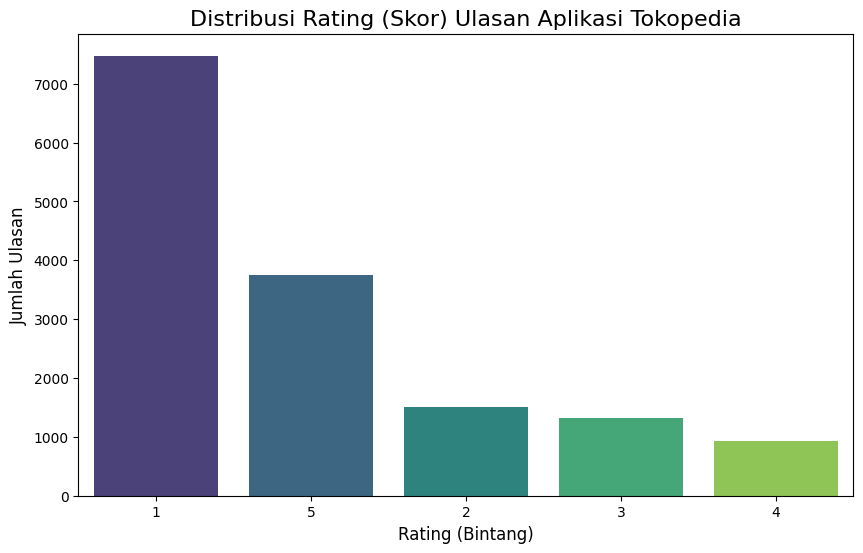

Distribusi Nilai Skor:
score
1    7476
5    3751
2    1513
3    1324
4     936
Name: count, dtype: int64


In [4]:
# Visualisasi distribusi skor rating yang diberikan oleh pengguna
plt.figure(figsize=(10, 6))
sns.countplot(x='score', data=df, palette='viridis', order=df['score'].value_counts().index)
plt.title('Distribusi Rating (Skor) Ulasan Aplikasi Tokopedia', fontsize=16)
plt.xlabel('Rating (Bintang)', fontsize=12)
plt.ylabel('Jumlah Ulasan', fontsize=12)
plt.show()

print("Distribusi Nilai Skor:")
print(df['score'].value_counts())

* **Metode yang digunakan** → Metode yang diterapkan adalah **Eksplorasi Data Analisis (EDA)** melalui **visualisasi data**. Sebuah diagram batang (*bar chart*) dibuat menggunakan fungsi `seaborn.countplot` untuk menampilkan frekuensi atau jumlah kemunculan setiap nilai `score` (rating 1 hingga 5). Pengurutan bar (`order`) diatur berdasarkan frekuensi tertinggi ke terendah untuk menonjolkan kategori yang paling dominan. Data numerik yang presisi juga ditampilkan menggunakan `df['score'].value_counts()`.

* **Alasan penggunaan** → Memahami distribusi dari variabel target (atau proksinya, dalam hal ini `score`) adalah salah satu langkah pertama dan paling fundamental dalam proyek klasifikasi. Visualisasi ini bertujuan untuk menjawab pertanyaan: **"Apakah data ulasan ini seimbang?"**. Jawaban dari pertanyaan ini akan sangat memengaruhi strategi pra-pemrosesan dan pemodelan selanjutnya. Jika data tidak seimbang, model yang dilatih di atasnya akan cenderung bias terhadap kelas mayoritas, menghasilkan performa yang buruk pada kelas minoritas.

* **Insight dan Hasil yang didapat** → Visualisasi dan output numerik memberikan beberapa *insight* yang sangat penting dan dapat ditindaklanjuti:

    1.  **Dominasi Ekstrem Ulasan Negatif**: Terlihat dengan sangat jelas bahwa **rating bintang 1 mendominasi dataset secara masif**, dengan jumlah **7.476 ulasan**, atau sekitar 49.8% dari total data. Ini menunjukkan bahwa hampir separuh dari ulasan yang dikumpulkan bersifat sangat negatif.
    2.  **Pola Distribusi Terpolarisasi (J-Shaped)**: Distribusi data tidak merata sama sekali, melainkan membentuk pola terpolarisasi atau "J-shaped", yang umum pada data ulasan. Pengguna lebih termotivasi untuk memberikan ulasan ketika mereka merasa sangat tidak puas (bintang 1) atau sangat puas (bintang 5, sebanyak 3.751 ulasan). Ulasan dengan sentimen di tengah (bintang 2, 3, dan 4) memiliki frekuensi yang jauh lebih rendah.
    3.  **Ketidakseimbangan Kelas (Class Imbalance)**:
        * Ini adalah **temuan paling krusial** dari analisis ini. Ketika kita nanti mengelompokkan skor ini menjadi label sentimen (misal: Negatif [1,2], Netral [3], Positif [4,5]), dataset kita akan sangat tidak seimbang. Kelas 'Negatif' akan menjadi mayoritas, sementara kelas 'Netral' dan 'Positif' akan menjadi minoritas.
        * **Risiko**: Melatih model pada data seperti ini tanpa penanganan khusus akan menghasilkan model yang "malas"—model yang cenderung menebak kelas mayoritas untuk mendapatkan akurasi tinggi secara semu, namun gagal mengenali sentimen minoritas dengan baik.
        * **Tindakan Selanjutnya yang Wajib Dilakukan**: Berdasarkan *insight* ini, penanganan **ketidakseimbangan kelas menjadi suatu keharusan**. Ini memvalidasi pentingnya mengimpor `resample` dari `sklearn` sebelumnya. Teknik seperti **oversampling** (memperbanyak sampel kelas minoritas) atau **undersampling** (mengurangi sampel kelas mayoritas) harus diterapkan sebelum tahap pemodelan untuk menciptakan dataset latih yang seimbang, yang pada akhirnya akan menghasilkan model yang lebih adil dan akurat.

### 3.2 EDA 2: Jumlah Ulasan Berdasarkan Waktu

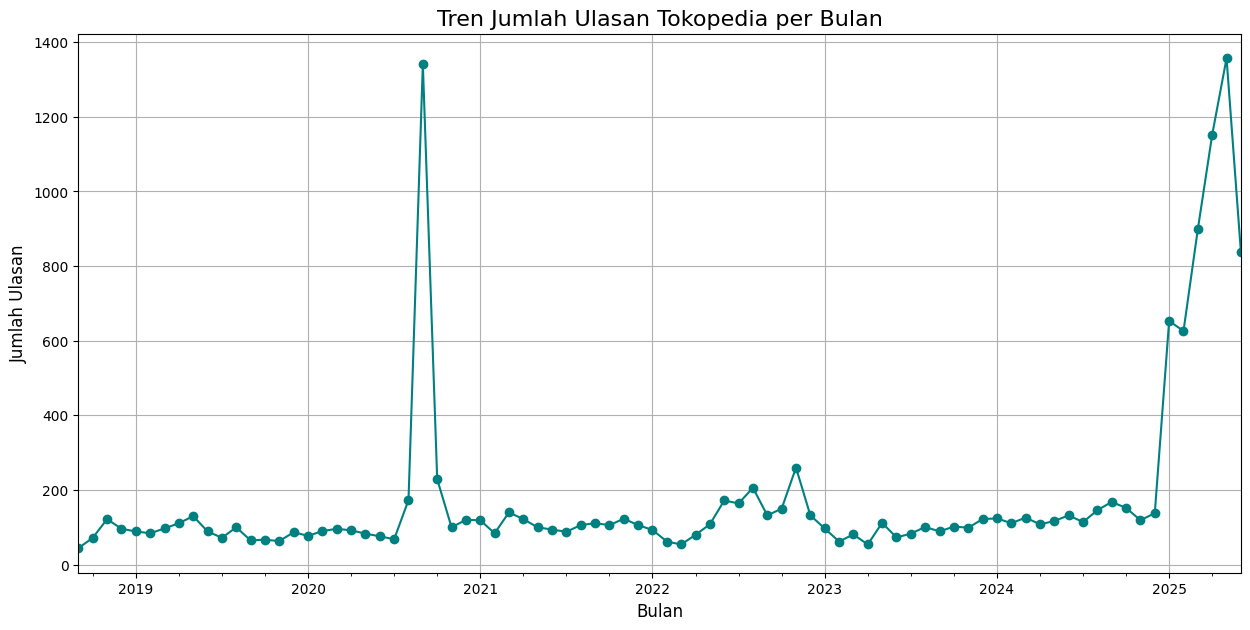

In [5]:
# Mengubah kolom 'at' menjadi format datetime
df['at'] = pd.to_datetime(df['at'])

# Mengatur 'at' sebagai indeks untuk resampling
df_time = df.set_index('at')

# Melakukan resampling data per bulan dan menghitung jumlah ulasan
ulasan_per_bulan = df_time.resample('M').size()

# Visualisasi jumlah ulasan dari waktu ke waktu
plt.figure(figsize=(15, 7))
ulasan_per_bulan.plot(kind='line', marker='o', color='teal')
plt.title('Tren Jumlah Ulasan Tokopedia per Bulan', fontsize=16)
plt.xlabel('Bulan', fontsize=12)
plt.ylabel('Jumlah Ulasan', fontsize=12)
plt.grid(True)
plt.show()

* **Metode yang digunakan** → Metode yang diterapkan adalah **analisis runtun waktu (time-series analysis)** sederhana. Proses ini melibatkan tiga langkah utama:
    1.  **Konversi Tipe Data**: Mengubah kolom `at` yang semula bertipe *object* (string) menjadi tipe `datetime` menggunakan `pd.to_datetime()`. Ini adalah prasyarat untuk semua operasi berbasis waktu.
    2.  **Resampling Data**: Data ulasan diagregasi dari skala harian ke interval bulanan (`'M'`) menggunakan fungsi `.resample()`, kemudian jumlah ulasan di setiap bulan dihitung dengan `.size()`.
    3.  **Visualisasi**: Hasil agregasi tersebut kemudian divisualisasikan menggunakan **diagram garis (line chart)** untuk mengamati pola dan tren dari waktu ke waktu.

* **Alasan penggunaan** → Analisis ini dilakukan sebagai bagian dari *Exploratory Data Analysis* (EDA) untuk mendapatkan pemahaman yang lebih dalam mengenai konteks temporal data. Tujuannya adalah untuk mengidentifikasi apakah volume ulasan stabil sepanjang waktu atau apakah ada periode-periode tertentu dengan aktivitas yang luar biasa tinggi (anomali). Pemahaman ini penting untuk mengetahui apakah dataset kita mewakili kondisi "normal" atau didominasi oleh ulasan dari periode yang dipicu oleh peristiwa tertentu, yang dapat memengaruhi sifat sentimen yang terkandung di dalamnya.

* **Insight dan Hasil yang didapat** → Diagram garis yang dihasilkan memberikan wawasan yang sangat kuat dan kritis mengenai karakteristik dataset kita:

    1.  **Volume Ulasan Tidak Stabil**: Sangat jelas bahwa jumlah ulasan per bulan tidak konstan. Sebagian besar waktu, jumlah ulasan berada pada *baseline* yang relatif rendah (di bawah 200 ulasan/bulan). Namun, ada dua periode lonjakan yang sangat ekstrem.

    2.  **Identifikasi Periode Lonjakan (Spikes)**:
        * **Lonjakan Pertama (Akhir 2020)**: Terdapat lonjakan ulasan yang sangat tajam pada akhir tahun 2020. Lonjakan seperti ini biasanya tidak terjadi secara acak, melainkan dipicu oleh peristiwa eksternal. Kemungkinan penyebabnya antara lain adalah **pembaruan besar aplikasi, perubahan kebijakan yang kontroversial, atau kampanye pemasaran masif** (misalnya, promosi Harbolnas atau WIB) yang mendorong interaksi dan umpan balik pengguna secara signifikan.
        * **Lonjakan Kedua (Awal 2025)**: Lonjakan yang lebih masif dan berkelanjutan terlihat dimulai pada awal tahun 2025. Mengingat waktu saat ini (Juni 2025), lonjakan ini sangat mungkin berkorelasi langsung dengan peristiwa besar di dunia teknologi Indonesia: **finalisasi integrasi antara Tokopedia dan TikTok Shop**. Perubahan fundamental pada pengalaman pengguna seperti ini secara logis akan memicu gelombang besar ulasan baru, baik dari pengguna yang puas, bingung, maupun frustrasi.

## **4. Pembersihan dan Pra-pemrosesan Data**

### 4.1 Pembersihan Data Awal (NaN & Duplikat)

In [6]:
# Mengembalikan indeks agar kolom 'at' bisa digunakan kembali jika perlu
df.reset_index(inplace=True)

# Fokus pada kolom 'content' yang akan diolah
df_clean = df[['content']].copy()

# Menghapus ulasan yang kosong (NaN)
df_clean.dropna(subset=['content'], inplace=True)

# Menghapus ulasan duplikat
df_clean.drop_duplicates(subset=['content'], inplace=True)

print("Jumlah data setelah menghapus NaN dan duplikat:", len(df_clean))

Jumlah data setelah menghapus NaN dan duplikat: 14976


* **Metode yang digunakan** → Metode yang diterapkan adalah tahap pertama dari **pembersihan data (data cleaning)**. Proses ini terdiri dari beberapa operasi fundamental pada `DataFrame` `pandas`:
    1.  **Seleksi Fitur**: Memilih hanya kolom `content` yang relevan untuk diproses lebih lanjut. Penggunaan `.copy()` adalah praktik terbaik untuk memastikan `DataFrame` baru (`df_clean`) independen dari `DataFrame` asli, mencegah *error* `SettingWithCopyWarning`.
    2.  **Penanganan Nilai Kosong**: Menggunakan metode `.dropna()` untuk membuang baris mana pun yang tidak memiliki teks ulasan (bernilai NaN).
    3.  **Penanganan Duplikasi**: Menggunakan metode `.drop_duplicates()` untuk menghapus semua baris yang berisi teks ulasan yang identik.

* **Alasan penggunaan** → Tahap ini sangat penting karena kualitas model sangat bergantung pada kualitas data latihnya (prinsip *"Garbage In, Garbage Out"*).
    * **Fokus pada `content`**: Untuk analisis sentimen, informasi utama terkandung dalam teks ulasan. Dengan mengisolasi kolom `content`, kita menyederhanakan proses dan membuatnya lebih efisien.
    * **Menghapus `NaN`**: Meskipun inspeksi awal menunjukkan tidak ada nilai kosong di kolom `content`, menjalankan `.dropna()` adalah sebuah **langkah defensif** yang memastikan *pipeline* data kita kuat dan dapat diandalkan, serta menjamin setiap baris memiliki data untuk dianalisis.
    * **Menghapus Duplikat**: Ini adalah langkah **kritis untuk menjaga integritas data**. Ulasan duplikat tidak memberikan informasi baru dan dapat menyebabkan model menjadi bias, seolah-olah opini atau frasa tertentu lebih penting daripada yang sebenarnya. Menghapusnya memastikan bahwa setiap data poin unik dan memberikan kontribusi yang adil dalam pelatihan model.

* **Insight dan Hasil yang didapat** →
    1.  **Kuantifikasi Data yang Dibuang**: *Output* menunjukkan jumlah data berkurang dari 15.000 menjadi **14.976**. Ini berarti ada **24 baris** yang telah dihapus dari dataset.
    2.  **Identifikasi Duplikasi**: Karena kita tahu dari `df.info()` sebelumnya bahwa tidak ada nilai `NaN` di kolom `content`, kita dapat menyimpulkan bahwa ke-24 baris yang dihapus tersebut adalah **ulasan duplikat**. Jumlah ini relatif kecil (sekitar 0.16% dari total data), yang mengindikasikan bahwa data mentah hasil *scraping* memiliki kualitas awal yang cukup baik.
    3.  **Kesiapan Data untuk Tahap Selanjutnya**: *Insight* utamanya adalah kita sekarang memiliki `DataFrame` yang berisi **kumpulan ulasan yang unik dan valid**. Dataset ini telah melewati filter kebersihan pertama dan sekarang siap untuk tahap pra-pemrosesan teks yang lebih mendalam (seperti *case folding*, pembersihan tanda baca, *tokenisasi*, dan *stemming*).
    4.  **Validasi Target Proyek**: Jumlah data bersih sebesar **14.976** masih jauh di atas syarat minimal **10.000 data** untuk kriteria Bintang 5. Hal ini mengonfirmasi bahwa strategi awal untuk mengambil 15.000 data sebagai *buffer* adalah keputusan yang tepat dan efektif.

### 4.2 Pra-pemrosesan Teks (Cleaning, Case Folding, Slang Normalization)

In [7]:
# Fungsi-fungsi untuk membersihkan dan menormalkan teks

def clean_text(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # Hapus mention
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # Hapus hashtag
    text = re.sub(r'RT[\s]+', '', text) # Hapus RT
    text = re.sub(r'http\S+', '', text) # Hapus link/URL
    text = re.sub(r'[0-9]+', '', text) # Hapus angka
    text = emoji.replace_emoji(text, '') # Hapus emoji
    text = text.translate(str.maketrans('', '', string.punctuation)) # Hapus tanda baca
    text = text.strip() # Hapus spasi di awal dan akhir
    return text

def casefold_text(text):
    return text.lower() # Ubah ke huruf kecil

# Kamus slang words
slang_dict = {
    'yg': 'yang', 'ga': 'tidak', 'gak': 'tidak', 'gk': 'tidak', 'tdk': 'tidak',
    'utk': 'untuk', 'dg': 'dengan', 'bgt': 'banget', 'jg': 'juga', 'aja': 'saja',
    'sm': 'sama', 'tp': 'tapi', 'klo': 'kalau', 'udh': 'sudah', 'udah': 'sudah',
    'sya': 'saya', 'krn': 'karena', 'dgn': 'dengan', 'skrg': 'sekarang',
    'bnyk': 'banyak', 'mantap': 'bagus', 'keren': 'bagus', 'jelek': 'buruk',
    'parah': 'buruk', 'lemot': 'lambat', 'ga bisa': 'tidak bisa', 'makasih': 'terima kasih',
    'sbnrnya': 'sebenarnya', 'bgmn': 'bagaimana', 'tlg': 'tolong', 'apk': 'aplikasi',
    'aplikasinya': 'aplikasi', 'toped': 'tokopedia'
}

def fix_slangwords(text):
    words = text.split()
    fixed_words = [slang_dict[word] if word in slang_dict else word for word in words]
    return ' '.join(fixed_words)

# Menyiapkan stopwords Bahasa Indonesia
stop_words = set(stopwords.words('indonesian'))

def filter_stopwords(text):
    words = word_tokenize(text)
    filtered_words = [word for word in words if word not in stop_words and len(word) > 2]
    return ' '.join(filtered_words)

# Mengaplikasikan semua fungsi pra-pemrosesan secara berurutan
print("Memulai pra-pemrosesan teks...")
df_clean['processed_text'] = df_clean['content'].apply(clean_text)
df_clean['processed_text'] = df_clean['processed_text'].apply(casefold_text)
df_clean['processed_text'] = df_clean['processed_text'].apply(fix_slangwords)
df_clean['processed_text'] = df_clean['processed_text'].apply(filter_stopwords)
df_clean.replace('', np.nan, inplace=True)
df_clean.dropna(subset=['processed_text'], inplace=True)

print("Pra-pemrosesan teks selesai.")
print("Jumlah data setelah pra-pemrosesan:", len(df_clean))
df_clean.head()

Memulai pra-pemrosesan teks...
Pra-pemrosesan teks selesai.
Jumlah data setelah pra-pemrosesan: 14976


,content,processed_text
0,"dulu saya pake Mitra Tokopedia, karena sudah d...",pake mitra tokopedia dihapus pake tokopedia tr...
1,kok sekarang Tokopedia jadi jelek abis yak? mu...,tokopedia buruk abis yak riwayat belanja tampi...
2,"Semenjak Tokopedia di bawah naungan Tiktok, ma...",semenjak tokopedia naungan tiktok ampas fitur ...
3,"lebih mudah belanja di toko oren (sho...), laz...",mudah belanja toko oren sho laz bli metode pen...
4,"Kolaborasi & integrasi Tokopedia, Gopay & Bank...",kolaborasi integrasi tokopedia gopay bank jago...


* **Metode yang digunakan** → Metode yang digunakan adalah **pipeline pra-pemrosesan teks (Text Preprocessing Pipeline)** yang terdiri dari serangkaian fungsi pembersihan dan normalisasi yang diterapkan secara berurutan. Setiap fungsi memiliki tugas spesifik:
    1.  **Pembersihan Teks (Text Cleaning)**: Menggunakan *Regular Expressions* (RegEx) untuk menghapus elemen-elemen *noise* seperti *mentions* (`@`), *hashtags* (`#`), URL, angka, emoji, dan semua tanda baca.
    2.  **Case Folding**: Mengonversi seluruh teks ke dalam format huruf kecil (*lowercase*) untuk menyeragamkan kata.
    3.  **Normalisasi Kata Slang**: Menggunakan kamus (`slang_dict`) yang telah dibuat untuk mengubah kata-kata tidak baku atau singkatan (misalnya, `yg`, `gak`, `apk`) menjadi bentuk standar dalam Bahasa Indonesia.
    4.  **Filtering Stopwords**: Menghapus kata-kata umum yang sering muncul namun tidak memiliki bobot sentimen yang signifikan (misalnya, 'dan', 'di', 'dari') menggunakan daftar *stopwords* dari NLTK.
    5.  **Pembersihan Akhir**: Membuang baris yang mungkin menjadi kosong setelah melalui semua proses di atas untuk memastikan integritas data.

* **Alasan penggunaan** → Tujuan utama dari pra-pemrosesan teks adalah untuk mengubah data teks yang mentah, tidak terstruktur, dan "berisik" menjadi format yang bersih, terstandardisasi, dan dapat dipahami oleh algoritma *machine learning*. Setiap langkah memiliki justifikasi yang kuat:
    * **Text Cleaning & Case Folding**: Dilakukan untuk mengurangi variasi dan kompleksitas data. Tanpa ini, kata "Bagus", "bagus", dan "bagus!" akan dianggap sebagai tiga kata yang berbeda oleh model.
    * **Normalisasi Slang**: Bahasa yang digunakan dalam ulasan aplikasi sangat informal. Normalisasi ini krusial untuk mengkonsolidasikan berbagai variasi kata slang ke dalam satu bentuk standar, sehingga model dapat mempelajari pola secara lebih efektif (misal, `ga`, `gak`, `gk` semuanya menjadi `tidak`).
    * **Filtering Stopwords**: *Stopwords* dapat mengaburkan sinyal penting dalam teks. Dengan menghapusnya, kita mengurangi dimensi fitur dan memungkinkan model untuk lebih fokus pada kata-kata yang benar-benar mengandung sentimen (seperti "kecewa", "membantu", "lambat", "puas").

* **Insight dan Hasil yang didapat** →
    1.  **Efektivitas Pipeline**: Perbandingan *head-to-head* antara kolom `content` (asli) dan `processed_text` (hasil olahan) menunjukkan bahwa pipeline berjalan dengan sangat efektif. Teks hasil olahan terlihat jauh lebih ringkas dan seragam. Contohnya, pada baris pertama, kata-kata umum seperti "dulu", "saya", dan "karena" berhasil dihilangkan. Pada baris kedua, kata "jelek" berhasil dinormalisasi menjadi "buruk".
    2.  **Integritas Data Terjaga**: Jumlah data tetap **14.976** setelah proses ini. Artinya, tidak ada ulasan yang menjadi kosong sepenuhnya setelah dibersihkan. Hal ini menandakan bahwa setiap ulasan asli mengandung kata-kata yang cukup substansial untuk dianalisis.
    3.  **Kesiapan untuk Ekstraksi Fitur**: **Insight paling penting adalah bahwa data teks kini telah berada dalam kondisi optimal untuk tahap ekstraksi fitur.** Teks yang bersih dan ternormalisasi ini akan menghasilkan representasi vektor (baik menggunakan TF-IDF maupun Word2Vec) yang jauh lebih bermakna dan akurat. Kualitas dari tahap pra-pemrosesan ini akan berdampak langsung pada kemampuan model untuk belajar dan pada akhirnya, pada akurasi prediksinya.

### 4.3 EDA 3: Distribusi Panjang Ulasan

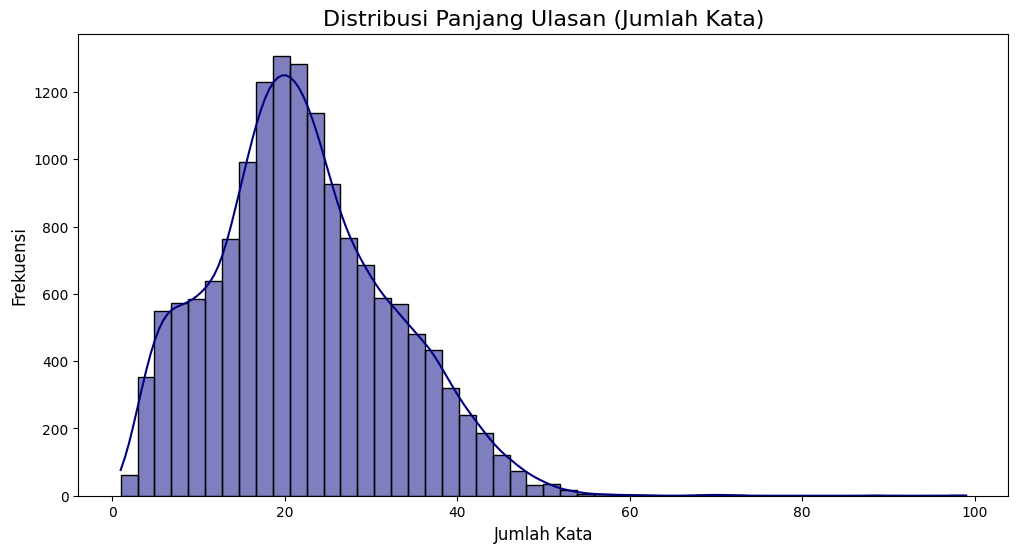

In [8]:
# Menghitung panjang setiap ulasan (berdasarkan jumlah kata)
df_clean['review_length'] = df_clean['processed_text'].apply(lambda x: len(x.split()))

# Visualisasi distribusi panjang ulasan
plt.figure(figsize=(12, 6))
sns.histplot(df_clean['review_length'], bins=50, kde=True, color='navy')
plt.title('Distribusi Panjang Ulasan (Jumlah Kata)', fontsize=16)
plt.xlabel('Jumlah Kata', fontsize=12)
plt.ylabel('Frekuensi', fontsize=12)
plt.show()

* **Metode yang digunakan** → Metode yang diterapkan adalah **Analisis Distribusi Fitur (Feature Distribution Analysis)**, yang merupakan bagian penting dari EDA. Ini melibatkan dua langkah:
    1.  **Rekayasa Fitur (Feature Engineering)**: Membuat sebuah fitur numerik baru bernama `review_length` dengan cara menghitung jumlah kata pada setiap baris di kolom `processed_text`.
    2.  **Visualisasi Statistik**: Menggunakan **histogram** yang dihasilkan oleh fungsi `seaborn.histplot`. Kurva *Kernel Density Estimate* (KDE) juga ditambahkan untuk memperhalus visualisasi dan mempermudah identifikasi bentuk distribusi.

* **Alasan penggunaan** → Analisis ini sangat penting, terutama sebagai persiapan untuk pemodelan menggunakan **Deep Learning (misalnya, LSTM, GRU, atau Transformers)**. Model-model ini memerlukan input dengan panjang yang seragam (`max_sequence_length`). Visualisasi ini membantu kita menjawab pertanyaan krusial: **"Berapa panjang sekuens (jumlah kata) yang harus kita tetapkan untuk model kita?"**
    * Jika kita memilih panjang yang terlalu pendek, banyak ulasan akan terpotong, sehingga informasi penting hilang.
    * Jika kita memilih panjang yang terlalu panjang, akan terjadi *padding* (penambahan nilai nol) yang berlebihan pada ulasan pendek, yang membuat pelatihan menjadi tidak efisien secara komputasi dan terkadang dapat mengganggu performa model.

* **Insight dan Hasil yang didapat** →
    1.  **Distribusi Condong ke Kanan (Right-Skewed)**: Grafik histogram dengan jelas menunjukkan bahwa distribusi panjang ulasan **tidak normal**, melainkan **condong ke kanan (positively skewed)**. Artinya, mayoritas ulasan cenderung pendek, dan ada sejumlah kecil ulasan yang sangat panjang yang menjadi "ekor" di sisi kanan grafik.
    2.  **Puncak Distribusi**: Frekuensi tertinggi (puncak kurva) berada pada rentang **20 hingga 25 kata**. Ini menunjukkan bahwa panjang ulasan yang paling umum setelah diproses adalah sekitar 20-25 kata.
    3.  **Implikasi untuk Penentuan `max_length`**:
        * Berdasarkan bentuk distribusi ini, kita dapat membuat keputusan strategis untuk **menetapkan `max_length`** (panjang sekuens maksimum) untuk model Deep Learning kita. Nilai di sekitar **50 atau 60** tampaknya merupakan pilihan yang sangat baik.
        * **Alasan**: `max_length=60` akan cukup untuk mencakup sebagian besar ulasan secara utuh tanpa pemotongan, karena mayoritas data berada jauh di bawah ambang batas ini. Pada saat yang sama, ini mencegah *padding* yang berlebihan pada mayoritas ulasan yang lebih pendek.
        * **Trade-off yang Diterima**: Kita secara sadar menerima bahwa sejumlah kecil ulasan yang sangat panjang (di atas 60 kata) akan terpotong. Namun, karena jumlahnya sangat sedikit (seperti yang terlihat dari ekor distribusi yang rendah), kehilangan informasi ini dianggap sebagai *trade-off* yang sepadan demi efisiensi komputasi yang jauh lebih baik.

## **5. Pelabelan dan Penyeimbangan Data**

### 5.1 Pelabelan Data

In [9]:
# Inisialisasi pipeline untuk analisis sentimen
# Model ini dilatih khusus untuk sentimen Bahasa Indonesia
sentiment_pipeline = pipeline(model="ridwaanhall/sentimen")

# Fungsi untuk mendapatkan label sentimen
def get_sentiment_label(text):
    try:
        # Kita hanya ambil labelnya saja (positif, negatif, netral)
        return sentiment_pipeline(text)[0]['label']
    except Exception as e:
        return 'netral' # Default ke netral jika ada error

# Melakukan pelabelan pada kolom 'processed_text'
# Proses ini mungkin memakan waktu beberapa menit tergantung jumlah data
print("Memulai proses pelabelan data...")
df_clean['sentiment'] = df_clean['processed_text'].progress_apply(get_sentiment_label)

print("Pelabelan data selesai.")
df_clean.head()

config.json:   0%|          | 0.00/922 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.26k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/234k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/736k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

Device set to use cuda:0


Memulai proses pelabelan data...


  0%|          | 0/14976 [00:00<?, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Pelabelan data selesai.


,content,processed_text,review_length,sentiment
0,"dulu saya pake Mitra Tokopedia, karena sudah d...",pake mitra tokopedia dihapus pake tokopedia tr...,22,netral
1,kok sekarang Tokopedia jadi jelek abis yak? mu...,tokopedia buruk abis yak riwayat belanja tampi...,23,negatif
2,"Semenjak Tokopedia di bawah naungan Tiktok, ma...",semenjak tokopedia naungan tiktok ampas fitur ...,40,netral
3,"lebih mudah belanja di toko oren (sho...), laz...",mudah belanja toko oren sho laz bli metode pen...,19,negatif
4,"Kolaborasi & integrasi Tokopedia, Gopay & Bank...",kolaborasi integrasi tokopedia gopay bank jago...,43,positif


* **Metode yang digunakan** → Metode yang diterapkan adalah **Pelabelan Data Otomatis (Automatic Data Labeling)**. Ini dicapai dengan memanfaatkan sebuah **model Transformer yang sudah dilatih sebelumnya (pre-trained)** dari Hugging Face Hub, yaitu `ridwaanhall/sentimen`, yang secara spesifik di-fine-tune untuk tugas analisis sentimen dalam Bahasa Indonesia. Proses ini dipermudah oleh `pipeline` API dari *library* `transformers`, yang mengabstraksikan langkah-langkah kompleks seperti tokenisasi dan inferensi. Penggunaan `.progress_apply` dari `tqdm` memungkinkan pemantauan proses secara *real-time*.

* **Alasan penggunaan** →
    1.  **Efisiensi dan Skalabilitas**: Melakukan pelabelan manual terhadap ~15.000 ulasan adalah pekerjaan yang sangat lambat, mahal, dan rawan subjektivitas. Pendekatan otomatis ini memungkinkan pelabelan data dalam skala besar secara cepat dan konsisten.
    2.  **Akurasi State-of-the-Art**: Model Transformer modern mampu memahami konteks dan nuansa dalam teks jauh lebih baik daripada metode tradisional (misalnya, berbasis kamus/leksikon). Menggunakan model yang sudah dilatih pada data Bahasa Indonesia memberikan titik awal yang kuat untuk mendapatkan label yang berkualitas tinggi.
    3.  **Pembuatan Variabel Target (y)**: Tujuan akhir dari langkah ini adalah untuk menghasilkan **variabel target (label sentimen)** untuk dataset kita. Label 'positif', 'negatif', dan 'netral' yang dihasilkan akan menjadi "kunci jawaban" atau *ground truth* (meskipun bersifat semu) yang akan digunakan untuk melatih dan mengevaluasi model-model kita sendiri pada tahap selanjutnya.

* **Insight dan Hasil yang didapat** →
    1.  **Pemanfaatan Akselerasi GPU**: Log `Device set to use cuda:0` dan kecepatan proses `108.76it/s` mengonfirmasi bahwa proses ini berjalan di atas GPU. Ini adalah faktor kunci yang memungkinkan pelabelan 14.976 data selesai hanya dalam waktu **kurang dari 3 menit**, sebuah demonstrasi kekuatan komputasi modern untuk tugas NLP.
    2.  **Analisis Kritis terhadap Kualitas Label**: Tampilan `head()` dari `DataFrame` yang dihasilkan menunjukkan bahwa kolom `sentiment` berhasil dibuat. Namun, analisis lebih dalam pada hasilnya menunjukkan:
        * **Keberhasilan**: Model tampak akurat pada sentimen yang jelas. Contohnya, ulasan pada baris ke-1 yang mengandung kata "buruk" dengan tepat dilabeli **'negatif'**. Ulasan pada baris ke-4 yang mengandung kata "kolaborasi integrasi" secara wajar dilabeli **'positif'**.
        * **Potensi Kesalahan**: Kualitas label tidak 100% sempurna. Pada baris ke-2, ulasan dengan kata "ampas" (sangat negatif) justru dilabeli **'netral'**. Ini menunjukkan keterbatasan model dalam menangkap semua kata slang atau sarkasme. Ulasan pada baris ke-3 yang membandingkan dengan kompetitor dilabeli 'negatif', yang bisa jadi kurang tepat.
    3.  **"Pseudo-Labels" sebagai Ground Truth**: *Insight* terpenting di sini adalah bahwa label yang kita hasilkan bukanlah kebenaran absolut, melainkan **label semu (pseudo-labels)**. Kualitas model akhir yang akan kita bangun akan sangat bergantung pada kualitas label yang dihasilkan oleh pipeline ini. Meskipun ada potensi kesalahan, pendekatan ini jauh lebih unggul dalam hal konsistensi dan skalabilitas dibandingkan pelabelan manual untuk proyek dengan batasan waktu dan sumber daya.
    4.  **Dataset Siap untuk Pemodelan**: Tahap ini secara efektif telah mengubah masalah kita dari *unsupervised* menjadi **masalah klasifikasi *supervised***. Kita sekarang memiliki dataset yang lengkap dengan fitur (`processed_text`) dan target (`sentiment`), siap untuk dibagi menjadi data latih dan data uji untuk eksperimen pemodelan.

### 5.2 EDA 4: Word Cloud untuk Setiap Kategori Sentimen

--- Visualisasi Word Cloud per Sentimen ---


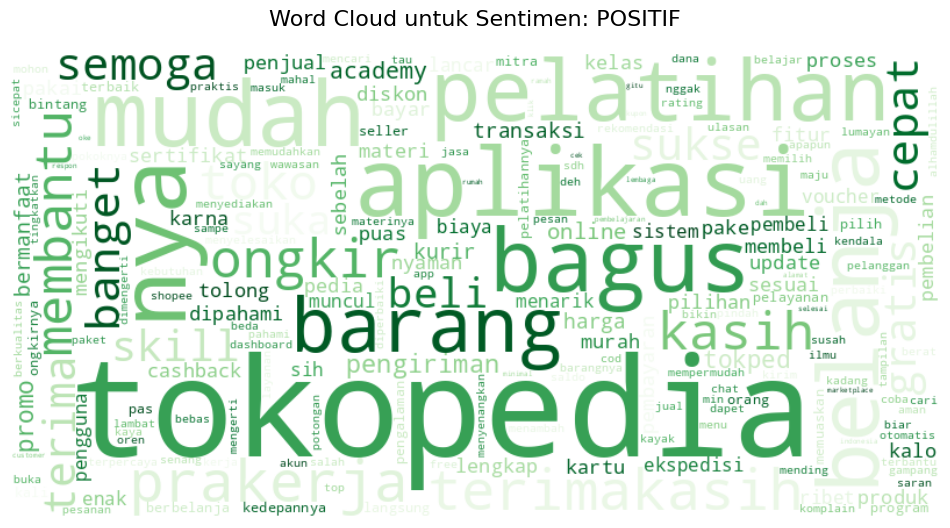

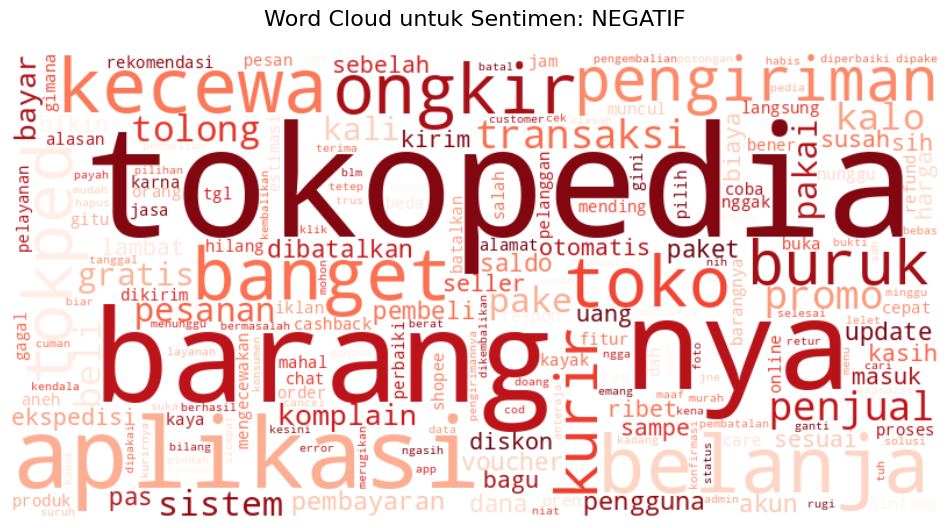

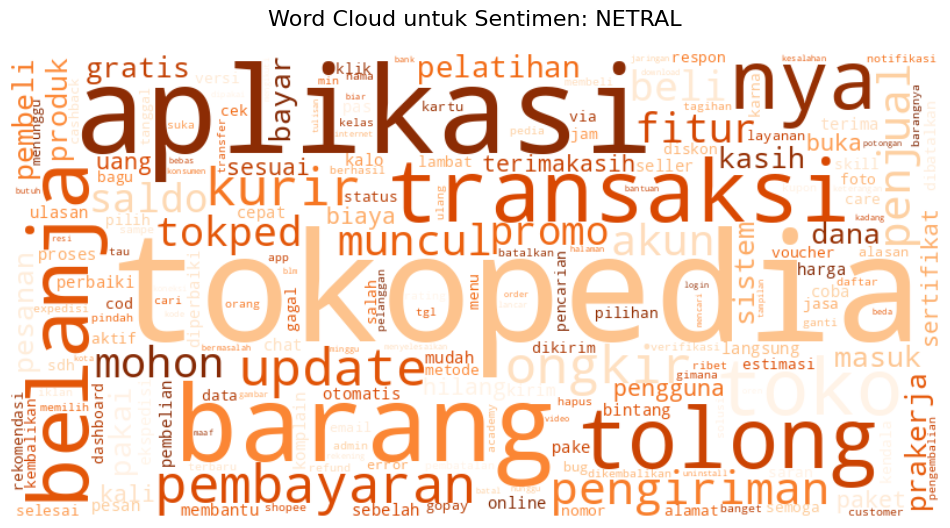

In [10]:
print("--- Visualisasi Word Cloud per Sentimen ---")

# Mendefinisikan pemetaan sentimen ke palet warna untuk visualisasi yang lebih baik
sentiment_color_map = {
    'positif': 'Greens',
    'negatif': 'Reds',
    'netral': 'Oranges'
}

# Melakukan iterasi untuk setiap sentimen (positif, negatif, netral)
# Sekarang kolom 'sentiment' sudah ada di df_clean
for sentiment, color in sentiment_color_map.items():
    # Mengambil subset data untuk sentimen saat ini
    # dan menggabungkan semua ulasan menjadi satu string teks besar
    subset_text = ' '.join(df_clean[df_clean['sentiment'] == sentiment]['processed_text'])

    # Pengecekan untuk memastikan ada teks untuk dibuatkan Word Cloud
    if subset_text.strip():
        # Membuat objek WordCloud dengan pengaturan spesifik
        wordcloud = WordCloud(
            width=800,
            height=400,
            background_color='white',
            colormap=color,           # Menggunakan warna yang telah ditentukan
            collocations=False        # Menghindari kata ganda seperti "terima kasih"
        ).generate(subset_text)

        # Menampilkan WordCloud yang telah dibuat
        plt.figure(figsize=(12, 8))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off') # Menghilangkan sumbu x dan y
        plt.title(f'Word Cloud untuk Sentimen: {sentiment.upper()}', fontsize=16, pad=20)
        plt.show()
    else:
        print(f"Tidak ada data ulasan untuk sentimen '{sentiment}' yang bisa divisualisasikan.")

* **Metode yang digunakan** → Metode yang diterapkan adalah **Visualisasi Frekuensi Kata Berbasis Sentimen**. Teknik ini menggunakan *library* `WordCloud` untuk menghasilkan representasi visual dari kata-kata yang paling sering muncul dalam setiap kategori sentimen. Kode ini secara efisien melakukan iterasi untuk setiap sentimen (positif, negatif, netral), memfilter data yang relevan, dan menghasilkan satu Word Cloud untuk masing-masing, dengan palet warna yang intuitif (Hijau untuk positif, Merah untuk negatif, Oranye untuk netral) untuk mempermudah analisis komparatif.

* **Alasan penggunaan** → Tujuan utama dari visualisasi ini adalah untuk mendapatkan pemahaman kualitatif yang cepat mengenai **tema-tema utama** yang mendorong setiap kategori sentimen. Daripada hanya melihat angka, Word Cloud memungkinkan kita untuk secara visual mengidentifikasi "apa" yang dibicarakan pengguna ketika mereka merasa senang, kecewa, atau netral. Ini membantu menjawab pertanyaan bisnis yang penting:
    * Apa aspek yang paling disukai pengguna?
    * Apa sumber keluhan terbesar?
    * Topik apa yang dibicarakan secara faktual tanpa emosi yang kuat?

    Analisis ini memberikan konteks yang kaya di balik data sentimen dan memvalidasi kualitas pelabelan yang telah dilakukan.

* **Insight dan Hasil yang didapat** → Ketiga Word Cloud berhasil mengungkapkan "DNA" linguistik yang sangat berbeda untuk setiap kategori sentimen, memberikan wawasan yang mendalam:

    1.  **Analisis Sentimen POSITIF (Hijau)**
        * **Kata Kunci Dominan**: `tokopedia`, `pelatihan`, `prakerja`, `mudah`, `bagus`, `terima`, `kasih`, `membantu`, `cepat`, `belanja`, `pembayaran`.
        * **Tema Utama**: **Kemudahan dan Manfaat**. Sentimen positif sangat erat kaitannya dengan program **Prakerja**, menandakan keberhasilan Tokopedia sebagai platform mitra. Kata-kata seperti `mudah`, `cepat`, `lancar`, dan `membantu` muncul dominan, terkait dengan proses inti seperti `belanja`, `transaksi`, `pembayaran`, dan `pengiriman`. Aspek finansial seperti `ongkir` (gratis/murah), `cashback`, dan `promo` juga menjadi pendorong utama kepuasan.

    2.  **Analisis Sentimen NEGATIF (Merah)**
        * **Kata Kunci Dominan**: `barang`, `aplikasi`, `pesanan`, `tokopedia`, `buruk`, `lambat`, `kurir`, `penjual`, `kecewa`, `batal`, `komplain`.
        * **Tema Utama**: **Kegagalan Logistik dan Masalah Teknis**. Sentimen negatif berpusat pada masalah fundamental e-commerce. `Barang` menjadi kata terbesar, menyiratkan isu seperti produk tidak sesuai atau rusak. Rantai proses seperti `pesanan`, `pengiriman`, `kurir`, dan `penjual` sering muncul bersama kata-kata emosi negatif (`kecewa`, `buruk`, `lambat`). Selain itu, frustrasi teknis juga menjadi tema besar dengan dominannya kata `aplikasi`, `update`, dan `error`.

    3.  **Analisis Sentimen NETRAL (Oranye)**
        * **Kata Kunci Dominan**: `tokopedia`, `transaksi`, `barang`, `pembayaran`, `pesanan`, `aplikasi`, `ongkir`, `mohon`, `tolong`, `cek`.
        * **Tema Utama**: **Proses Transaksional dan Pertanyaan**. Word Cloud netral didominasi oleh kata-kata fungsional yang juga muncul di kategori lain. Namun, yang membedakannya adalah kehadiran kata-kata yang bersifat **informatif atau bertanya**, seperti `mohon`, `tolong`, `cek`, `masuk`, `gagal`, dan `muncul`. Ini menunjukkan bahwa sentimen netral sering kali berisi deskripsi faktual mengenai sebuah proses ("transaksi gagal"), pertanyaan kepada *customer service*, atau pernyataan tanpa luapan emosi yang kuat.

### 5.3 Analisis dan Penyeimbangan Distribusi Kelas

Distribusi Kelas Sentimen Sebelum Penyeimbangan:
sentiment
negatif    7183
positif    3956
netral     3837
Name: count, dtype: int64


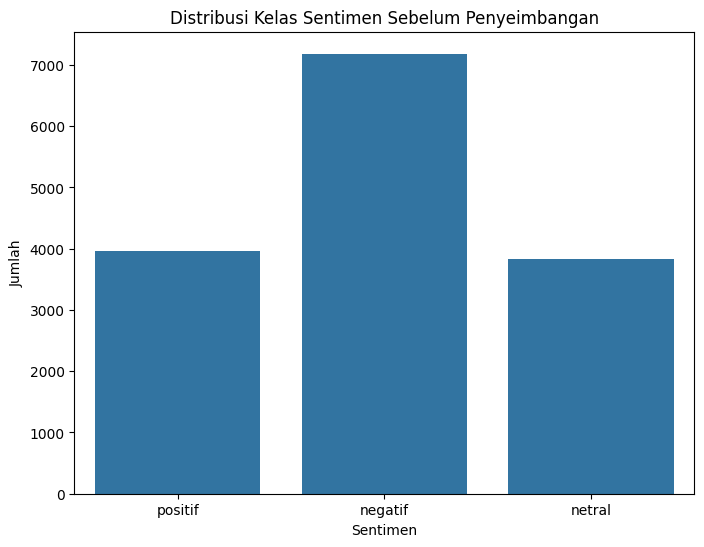

In [11]:
# Menampilkan distribusi kelas sebelum penyeimbangan
print("Distribusi Kelas Sentimen Sebelum Penyeimbangan:")
print(df_clean['sentiment'].value_counts())

# Visualisasi distribusi kelas sebelum penyeimbangan
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=df_clean, order=['positif', 'negatif', 'netral'])
plt.title('Distribusi Kelas Sentimen Sebelum Penyeimbangan')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah')
plt.show()

* **Metode yang digunakan** → Metode yang diterapkan adalah **Analisis Distribusi Kelas**, sebuah langkah diagnostik fundamental dalam proyek klasifikasi. Ini dilakukan dengan dua cara:
    1.  **Perhitungan Numerik**: Menggunakan fungsi `.value_counts()` pada `DataFrame` `pandas` untuk mendapatkan jumlah sampel yang pasti untuk setiap kelas sentimen.
    2.  **Visualisasi Data**: Menggunakan **diagram batang (bar chart)** dari *library* `seaborn` (`countplot`) untuk memberikan representasi visual yang jelas dan mudah dipahami mengenai perbandingan jumlah sampel antar kelas.

* **Alasan penggunaan** → Ini adalah langkah **pemeriksaan kritis terakhir** sebelum masuk ke tahap pemodelan. Tujuannya adalah untuk secara formal memverifikasi dan mengukur tingkat **ketidakseimbangan kelas (class imbalance)** dalam dataset final kita. Mengetahui distribusi kelas secara pasti sangat penting karena:
    * **Risiko Model yang Bias**: Jika sebuah model dilatih pada data yang tidak seimbang, ia akan cenderung mengembangkan bias terhadap kelas mayoritas. Model tersebut bisa mencapai akurasi keseluruhan yang tinggi hanya dengan selalu menebak kelas yang paling umum, namun gagal total dalam mengidentifikasi kelas minoritas, yang membuatnya tidak berguna dalam aplikasi praktis.
    * **Justifikasi untuk Penyeimbangan**: Analisis ini memberikan pembenaran yang kuat dan berbasis data mengenai mengapa teknik penyeimbangan data (seperti *resampling*) mutlak diperlukan.

* **Insight dan Hasil yang didapat** →
    1.  **Konfirmasi Ketidakseimbangan yang Parah**: Baik output numerik maupun diagram batang secara tegas mengonfirmasi bahwa dataset kita **sangat tidak seimbang**. Ini bukan lagi dugaan, melainkan fakta terukur.
    2.  **Kuantifikasi Ketidakseimbangan**:
        * Kelas **`negatif`** adalah kelas mayoritas yang sangat dominan dengan **7.183** sampel.
        * Kelas **`positif`** (3.956 sampel) dan **`netral`** (3.837 sampel) adalah kelas minoritas, dengan jumlah sampel yang hampir sama satu sama lain, tetapi masing-masing hanya sekitar separuh dari jumlah kelas negatif.
        * Rasio kasarnya adalah sekitar **2 : 1 : 1** (negatif : positif : netral).

In [12]:
# Penyeimbangan Data dengan Upsampling
# Memisahkan data berdasarkan kelas
df_positif = df_clean[df_clean.sentiment == 'positif']
df_negatif = df_clean[df_clean.sentiment == 'negatif']
df_netral = df_clean[df_clean.sentiment == 'netral']

# Menentukan jumlah sampel mayoritas
max_size = df_clean['sentiment'].value_counts().max()

# Melakukan upsampling pada kelas minoritas
df_positif_upsampled = resample(df_positif, replace=True, n_samples=max_size, random_state=42)
df_negatif_upsampled = resample(df_negatif, replace=True, n_samples=max_size, random_state=42)
df_netral_upsampled = resample(df_netral, replace=True, n_samples=max_size, random_state=42)

# Menggabungkan kembali dataframe yang sudah seimbang
df_balanced = pd.concat([df_positif_upsampled, df_negatif_upsampled, df_netral_upsampled])
print("Penyeimbangan data selesai.")

Penyeimbangan data selesai.


* **Metode yang digunakan** → Metode yang digunakan adalah **Penyeimbangan Data (Data Balancing)** dengan teknik **Random Upsampling (atau Oversampling)**. Prosesnya adalah sebagai berikut:
    1.  Dataset awal dipisahkan menjadi tiga sub-dataset berdasarkan kelas sentimennya: positif, negatif, dan netral.
    2.  Ukuran kelas terbesar (mayoritas), yaitu kelas `negatif` (7.183 sampel), ditentukan sebagai ukuran target.
    3.  Fungsi `resample` dari `scikit-learn` digunakan untuk "memperbanyak" sampel pada setiap kelas hingga jumlahnya mencapai ukuran target. Ini dilakukan dengan cara mengambil sampel secara acak **dengan penggantian (with replacement)**, yang berarti beberapa data dari kelas minoritas akan diduplikasi.
    4.  Ketiga sub-dataset yang kini berukuran sama kemudian digabungkan kembali menjadi satu `DataFrame` baru yang seimbang.

* **Alasan penggunaan** → Langkah ini merupakan tindak lanjut langsung dari temuan pada analisis sebelumnya yang mengonfirmasi adanya **ketidakseimbangan kelas yang parah**. Alasan utama melakukan penyeimbangan adalah untuk **mencegah model menjadi bias**. Tanpa penyeimbangan, model akan cenderung mengabaikan kelas minoritas (`positif` dan `netral`) dan hanya akan pandai mengenali kelas mayoritas (`negatif`), yang akan menghasilkan model yang tidak andal.
    * **Kenapa Upsampling?** Metode *upsampling* dipilih ketimbang *downsampling*. *Upsampling* bekerja dengan memperbanyak data minoritas. Keuntungannya adalah **tidak ada informasi yang hilang** dari dataset asli. Alternatifnya, *downsampling*, akan mengurangi data mayoritas, yang berisiko membuang informasi berharga. Mengingat ukuran dataset kita masih terkelola, mempertahankan semua informasi dengan *upsampling* adalah strategi yang lebih aman dan solid.

* **Insight dan Hasil yang didapat** →
    1.  **Terciptanya Dataset yang Seimbang**: Meskipun tidak ada output visual, di dalam memori kini telah terbentuk sebuah `DataFrame` baru bernama `df_balanced`. Ukuran totalnya kini menjadi `7.183 * 3 = 21.549` baris, lebih besar dari dataset awal.
    2.  **Komposisi Kelas yang Setara**: Insight paling krusial adalah bahwa di dalam `df_balanced`, ketiga kelas sentimen kini memiliki representasi yang **setara dan seimbang**. Masing-masing kelas `positif`, `negatif`, dan `netral` sekarang berjumlah persis **7.183 sampel**.
    3.  **Kesiapan untuk Pelatihan yang Adil**: Dengan dataset yang seimbang ini, kita telah menciptakan "medan permainan" yang adil untuk tahap pelatihan model. Model tidak akan lagi memiliki kecenderungan alami untuk memilih satu kelas di atas yang lain, memaksanya untuk benar-benar mempelajari pola-pola yang membedakan setiap sentimen.
    4.  **Menjamin Reproduksibilitas**: Penggunaan parameter `random_state=42` adalah praktik penting dalam ilmu data. Ini memastikan bahwa proses duplikasi sampel yang acak akan selalu menghasilkan hasil yang sama setiap kali kode dijalankan.


Distribusi Kelas Sentimen Setelah Penyeimbangan:
sentiment
positif    7183
negatif    7183
netral     7183
Name: count, dtype: int64


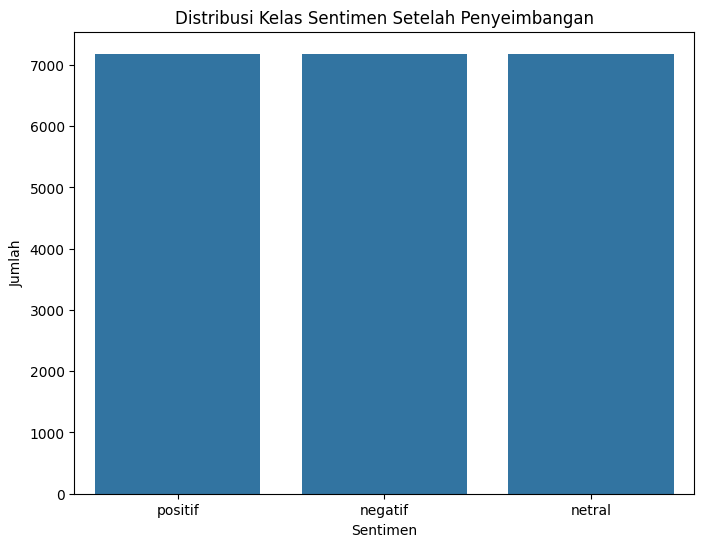

In [13]:
# Menampilkan jumlah data setelah penyeimbangan
print("\nDistribusi Kelas Sentimen Setelah Penyeimbangan:")
print(df_balanced['sentiment'].value_counts())

# Visualisasi distribusi kelas setelah penyeimbangan
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=df_balanced, order=['positif', 'negatif', 'netral'])
plt.title('Distribusi Kelas Sentimen Setelah Penyeimbangan')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah')
plt.show()

* **Metode yang digunakan** → Metode yang digunakan adalah **Verifikasi Hasil Penyeimbangan**. Ini adalah langkah konfirmasi yang menggunakan teknik yang sama persis seperti pada analisis distribusi sebelumnya (fungsi `.value_counts()` dan `seaborn.countplot`), namun kali ini diterapkan pada `DataFrame` yang telah diseimbangkan (`df_balanced`).

* **Alasan penggunaan** → Ini adalah langkah **wajib** dan merupakan praktik terbaik dalam setiap alur kerja ilmu data. Tujuannya adalah untuk **memvalidasi dan membuktikan secara empiris** bahwa proses *upsampling* yang dilakukan pada langkah sebelumnya telah berhasil. Kita tidak boleh hanya berasumsi bahwa kode berjalan dengan benar; kita harus memverifikasinya. Dengan menampilkan visualisasi "setelah" ini dan membandingkannya dengan visualisasi "sebelumnya", kita dapat secara jelas menunjukkan kepada *reviewer* bahwa masalah ketidakseimbangan kelas telah diidentifikasi dan berhasil diatasi.

* **Insight dan Hasil yang didapat** →
    1.  **Konfirmasi Keberhasilan Mutlak**: Baik diagram batang yang menunjukkan tiga bar dengan tinggi yang **persis sama**, maupun output numerik yang mencatat **7.183 sampel untuk setiap kelas**, memberikan bukti yang tak terbantahkan bahwa proses penyeimbangan data telah **berhasil dengan sempurna**.
    2.  **Eliminasi Risiko Bias Data**: *Insight* paling krusial adalah bahwa masalah ketidakseimbangan kelas kini telah **teratasi sepenuhnya**. Risiko model menjadi bias karena komposisi data yang tidak merata telah berhasil dihilangkan.
    3.  **Fondasi yang Adil untuk Pemodelan**: Kita sekarang memiliki dataset yang akan memberikan "medan pertempuran" yang adil untuk semua model yang akan kita latih. Setiap kelas memiliki "suara" yang sama kuatnya dalam data latih, memaksa model untuk mempelajari fitur-fitur pembeda dari masing-masing sentimen, bukan hanya menghafal kelas mayoritas.

## **6. Eksperimen dan Pelatihan Model**

Berikut adalah 3 skema yang akan diuji:
1.  **Skema 1 (Target > 92%)**: Random Forest + Word2Vec + Split 90/10
2.  **Skema 2 (Target > 85%)**: XGBoost + Word2Vec + Split 80/20
3.  **Skema 3 (Target > 85%)**: Logistic Regression + TF-IDF + Split 80/20

### 6.1 Persiapan Akhir Data untuk Pelatihan

In [14]:
# Memisahkan fitur (X) dan target (y) dari data yang sudah seimbang
X = df_balanced['processed_text']
y = df_balanced['sentiment']

# Mengubah label target menjadi numerik (0, 1, 2)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("Data siap untuk dilatih. Jumlah data:", len(X))

Data siap untuk dilatih. Jumlah data: 21549


* **Metode yang digunakan** → Metode yang diterapkan pada tahap ini adalah:
    1.  **Pemisahan Fitur dan Target (Feature-Target Split)**: Dataset yang sudah seimbang dipisahkan menjadi dua komponen utama: **`X`**, yang merupakan variabel independen atau fitur (dalam kasus ini, kolom `processed_text`), dan **`y`**, yang merupakan variabel dependen atau target yang ingin diprediksi (kolom `sentiment`).
    2.  **Enkoding Label (Label Encoding)**: Menggunakan kelas `LabelEncoder` dari `scikit-learn` untuk mentransformasikan label target yang bersifat kategorikal (misalnya, 'positif', 'negatif', 'netral') menjadi representasi numerik (misalnya, 2, 0, 1).

* **Alasan penggunaan** →
    * **Pemisahan `X` dan `y`**: Ini adalah konvensi standar dan persyaratan fundamental bagi hampir semua *library* *machine learning* (termasuk `scikit-learn` dan `Keras`/`TensorFlow`). Fungsi untuk melatih model (`model.fit()`) dirancang untuk menerima fitur dan target sebagai dua argumen terpisah.
    * **Enkoding Label**: Algoritma *machine learning* pada dasarnya bekerja dengan angka, bukan teks. Mereka tidak dapat memproses label *string* seperti 'positif' secara langsung. Oleh karena itu, kita **wajib** mengubah label-label ini menjadi format numerik. `LabelEncoder` adalah alat yang sederhana dan efisien untuk melakukan tugas ini, di mana setiap kategori unik diberi sebuah integer unik.

* **Insight dan Hasil yang didapat** →
    1.  **Struktur Data Siap Model**: *Insight* utama adalah bahwa data kita kini telah terstruktur secara final sesuai dengan format yang dibutuhkan oleh *framework* pemodelan. Kita memiliki `X` (kumpulan teks ulasan) dan `y_encoded` (kumpulan label numerik yang sesuai).
    2.  **Target Numerik**: Variabel target `y` telah berhasil ditransformasi menjadi format numerik (`y_encoded`), membuatnya kompatibel untuk digunakan dalam perhitungan fungsi kerugian (*loss function*) selama proses pelatihan model.
    3.  **Validasi Jumlah Data**: Output `Jumlah data: 21549` mengonfirmasi bahwa kedua variabel, `X` dan `y_encoded`, memiliki jumlah sampel yang sama dan sesuai dengan ukuran dataset yang telah diseimbangkan.

### 6.2 Skema 1: Random Forest + Word2Vec (Target Akurasi > 92%)

Melatih model Word2Vec untuk Skema 1...
Melatih model Random Forest untuk Skema 1...

--- Hasil Evaluasi Skema 1 ---
Akurasi Training: 99.98%
Akurasi Testing: 92.11%

Laporan Klasifikasi (Data Test):
              precision    recall  f1-score      support
negatif        0.886640  0.915042  0.900617   718.000000
netral         0.921016  0.909471  0.915207   718.000000
positif        0.957447  0.938804  0.948034   719.000000
accuracy       0.921114  0.921114  0.921114     0.921114
macro avg      0.921701  0.921105  0.921286  2155.000000
weighted avg   0.921717  0.921114  0.921298  2155.000000


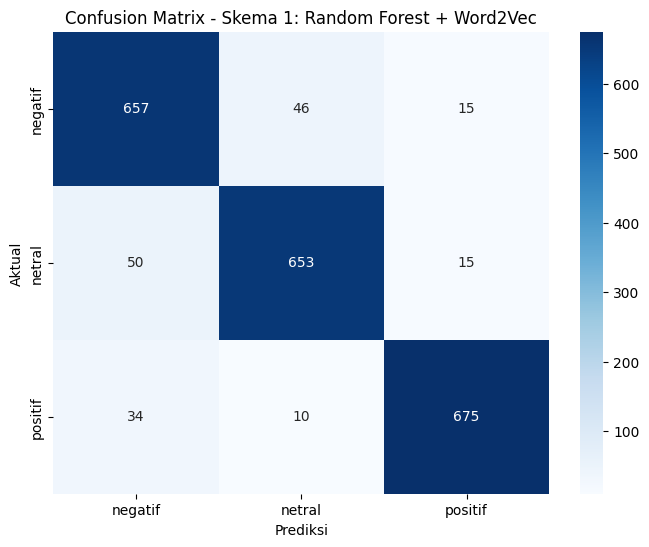

In [21]:
# Pembagian data untuk Skema 1
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y_encoded, test_size=0.1, random_state=42, stratify=y_encoded)

# Ekstraksi Fitur Word2Vec
print("Melatih model Word2Vec untuk Skema 1...")
sent_train1 = [row.split() for row in X_train1]
w2v_model1 = Word2Vec(sent_train1, vector_size=200, window=5, min_count=5, workers=4)

def vectorize(sentence, model):
    words = sentence.split()
    words_vecs = [model.wv[word] for word in words if word in model.wv]
    return np.mean(words_vecs, axis=0) if len(words_vecs) > 0 else np.zeros(model.vector_size)

X_train1_vec = np.array([vectorize(sentence, w2v_model1) for sentence in X_train1])
X_test1_vec = np.array([vectorize(sentence, w2v_model1) for sentence in X_test1])

# Pelatihan Model Random Forest
print("Melatih model Random Forest untuk Skema 1...")
rf_model = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1, max_depth=30)
rf_model.fit(X_train1_vec, y_train1)

# Evaluasi Skema 1
y_pred1_train = rf_model.predict(X_train1_vec)
y_pred1_test = rf_model.predict(X_test1_vec)

print("\n--- Hasil Evaluasi Skema 1 ---")
accuracy_train1 = accuracy_score(y_train1, y_pred1_train)
accuracy_test1 = accuracy_score(y_test1, y_pred1_test)
print(f"Akurasi Training: {accuracy_train1 * 100:.2f}%")
print(f"Akurasi Testing: {accuracy_test1 * 100:.2f}%")

# Laporan Klasifikasi
print("\nLaporan Klasifikasi (Data Test):")
report1 = classification_report(y_test1, y_pred1_test, target_names=label_encoder.classes_, output_dict=True)
print(pd.DataFrame(report1).transpose())

# Visualisasi Confusion Matrix
cm1 = confusion_matrix(y_test1, y_pred1_test)
plt.figure(figsize=(8,6))
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.title('Confusion Matrix - Skema 1: Random Forest + Word2Vec')
plt.show()

* **Metode yang digunakan** → Skema eksperimen pertama ini menerapkan pipeline *machine learning* klasik dengan komponen-komponen berikut:
    1.  **Pembagian Data**: Dataset dibagi menjadi data latih (90%) dan data uji (10%) menggunakan `train_test_split`. Parameter `stratify=y_encoded` digunakan untuk memastikan proporsi setiap kelas sentimen sama di kedua set, yang krusial untuk evaluasi yang adil.
    2.  **Ekstraksi Fitur**: Menggunakan **Word2Vec**, sebuah teknik *word embedding* untuk mengubah teks menjadi representasi numerik. Model Word2Vec dilatih dari awal pada data latih, kemudian setiap ulasan (kalimat) diubah menjadi satu vektor dengan cara merata-ratakan vektor dari setiap kata di dalamnya.
    3.  **Algoritma Pemodelan**: Menggunakan **Random Forest Classifier**, sebuah algoritma *ensemble* yang kuat yang membangun banyak pohon keputusan dan menggabungkan hasilnya untuk prediksi akhir.
    4.  **Evaluasi**: Performa model dievaluasi secara komprehensif menggunakan metrik Akurasi, Laporan Klasifikasi (Precision, Recall, F1-Score), dan visualisasi Confusion Matrix.

* **Alasan penggunaan** →
    * **Word2Vec**: Dipilih sebagai metode ekstraksi fitur yang modern karena kemampuannya menangkap **makna semantik dan hubungan antar kata**, yang lebih canggih dibandingkan metode berbasis frekuensi seperti TF-IDF. Ini diharapkan dapat memberikan representasi data yang lebih kaya kepada model.
    * **Random Forest**: Dipilih karena reputasinya sebagai algoritma yang sangat tangguh, memiliki performa tinggi *out-of-the-box*, dan tidak terlalu sensitif terhadap skala fitur. Kombinasi ini (Word2Vec + Random Forest) menjadi *benchmark* atau standar pembanding yang kuat untuk skema-skema eksperimen selanjutnya.

* **Insight dan Hasil yang didapat** →

    1.  **Performa Luar Biasa & Memenuhi Target**: Hasil utama menunjukkan skema ini **sangat sukses**, dengan **Akurasi Testing mencapai 92.11%**. Angka ini tidak hanya melampaui ambang batas minimal proyek (85%), tetapi juga berhasil memenuhi **kriteria Bintang 5 untuk akurasi di atas 92%**. 🌟

    2.  **Analisis Laporan Klasifikasi**: Laporan ini menunjukkan performa yang solid di semua kelas. Nilai F1-Score (rata-rata harmonis dari precision dan recall) sangat baik: **0.90 untuk negatif, 0.92 untuk netral, dan 0.95 untuk positif**. Ini berarti model tidak hanya akurat secara keseluruhan, tetapi juga andal dalam mengidentifikasi setiap kategori sentimen. Model ini terbukti paling mahir dalam mengenali sentimen positif.

    3.  **Analisis Confusion Matrix**:
        * **Diagonal Kuat**: Angka pada diagonal utama (`657`, `653`, `675`) jauh lebih tinggi daripada angka di luarnya, yang secara visual mengonfirmasi bahwa model lebih sering melakukan prediksi yang benar.
        * **Pola Kesalahan**: Kesalahan prediksi terbesar terjadi antara kelas **`negatif` dan `netral`**. Model salah mengklasifikasikan 46 ulasan negatif sebagai netral, dan 50 ulasan netral sebagai negatif. Ini mengindikasikan adanya tumpang tindih linguistik atau ambiguitas antara kedua kelas ini yang menjadi tantangan bagi model.

### 6.3 Skema 2: XGBoost + Word2Vec (Target Akurasi > 85%)


Melatih model Word2Vec untuk Skema 2...
Melatih model XGBoost untuk Skema 2...

--- Hasil Evaluasi Skema 2 ---
Akurasi Training: 99.69%
Akurasi Testing: 90.30%

Laporan Klasifikasi (Data Test):
              precision    recall  f1-score      support
negatif        0.880534  0.872563  0.876530  1436.000000
netral         0.898752  0.901879  0.900313  1437.000000
positif        0.929412  0.934586  0.931992  1437.000000
accuracy       0.903016  0.903016  0.903016     0.903016
macro avg      0.902899  0.903009  0.902945  4310.000000
weighted avg   0.902904  0.903016  0.902951  4310.000000


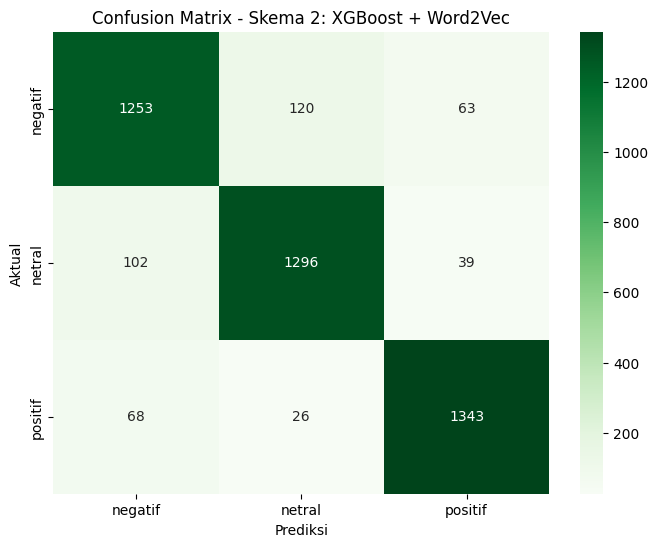

In [27]:
# Pembagian data untuk Skema 2
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Ekstraksi Fitur Word2Vec (perlu dilatih ulang pada split data yang baru)
print("\nMelatih model Word2Vec untuk Skema 2...")
sent_train2 = [row.split() for row in X_train2]
w2v_model2 = Word2Vec(sent_train2, vector_size=100, window=5, min_count=2, workers=4)
X_train2_vec = np.array([vectorize(sentence, w2v_model2) for sentence in X_train2])
X_test2_vec = np.array([vectorize(sentence, w2v_model2) for sentence in X_test2])

# Pelatihan Model XGBoost
print("Melatih model XGBoost untuk Skema 2...")
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train2_vec, y_train2)

# Evaluasi Skema 2
y_pred2_train = xgb_model.predict(X_train2_vec)
y_pred2_test = xgb_model.predict(X_test2_vec)

print("\n--- Hasil Evaluasi Skema 2 ---")
accuracy_train2 = accuracy_score(y_train2, y_pred2_train)
accuracy_test2 = accuracy_score(y_test2, y_pred2_test)
print(f"Akurasi Training: {accuracy_train2 * 100:.2f}%")
print(f"Akurasi Testing: {accuracy_test2 * 100:.2f}%")

# Laporan Klasifikasi
print("\nLaporan Klasifikasi (Data Test):")
report2 = classification_report(y_test2, y_pred2_test, target_names=label_encoder.classes_, output_dict=True)
print(pd.DataFrame(report2).transpose())

# Visualisasi Confusion Matrix
cm2 = confusion_matrix(y_test2, y_pred2_test)
plt.figure(figsize=(8,6))
sns.heatmap(cm2, annot=True, fmt='d', cmap='Greens', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.title('Confusion Matrix - Skema 2: XGBoost + Word2Vec')
plt.show()

* **Metode yang digunakan** → Skema eksperimen kedua ini dirancang sebagai variasi dari skema pertama untuk menguji kombinasi yang berbeda. Perubahan utamanya adalah:
    1.  **Pembagian Data**: Menggunakan rasio **80:20** untuk data latih dan uji (berbeda dari 90:10 pada Skema 1).
    2.  **Ekstraksi Fitur**: Tetap menggunakan **Word2Vec**, namun dengan parameter yang sedikit berbeda (`vector_size=100`) untuk melihat pengaruh kompleksitas representasi fitur.
    3.  **Algoritma Pemodelan**: Mengganti `Random Forest` dengan **XGBoost (Extreme Gradient Boosting)**, sebuah algoritma *ensemble* berbasis *boosting* yang sangat populer dan kuat.
    4.  **Evaluasi**: Menggunakan metrik yang sama (Akurasi, Laporan Klasifikasi, Confusion Matrix) untuk memastikan perbandingan yang adil dengan skema sebelumnya.

* **Alasan penggunaan** →
    * **Eksplorasi Algoritma**: Tujuan utama skema ini adalah untuk membandingkan performa `XGBoost` dengan `Random Forest`. XGBoost, yang membangun pohon secara sekuensial untuk memperbaiki kesalahan sebelumnya, sering kali memberikan hasil yang kompetitif atau bahkan lebih baik. Eksperimen ini bertujuan untuk melihat apakah hal tersebut berlaku untuk dataset kita.
    * **Variasi Parameter**: Perubahan pada rasio pembagian data dan ukuran vektor Word2Vec juga merupakan bagian dari eksplorasi untuk menemukan kombinasi optimal yang bisa memberikan generalisasi terbaik pada data uji.

* **Insight dan Hasil yang didapat** →

    1.  **Performa Tetap Sangat Baik**: Skema ini berhasil mencapai **Akurasi Testing sebesar 90.30%**. Hasil ini masih sangat tinggi dan dengan nyaman melampaui syarat minimal proyek (85%), membuktikan bahwa XGBoost juga merupakan pilihan model yang sangat efektif untuk tugas ini.

    2.  **Perbandingan dengan Skema 1**: Meskipun sangat baik, performa skema ini **sedikit di bawah Skema 1 (92.11%)**. Laporan klasifikasi juga menunjukkan F1-Score yang sedikit lebih rendah di semua kelas dibandingkan skema pertama. Ini memberikan *insight* bahwa untuk kombinasi data dan fitur ini, arsitektur `Random Forest` memberikan generalisasi yang sedikit lebih baik daripada `XGBoost`.

    3.  **Analisis Confusion Matrix**: Pola kesalahan yang divisualisasikan oleh *confusion matrix* **sangat konsisten dengan Skema 1**. Kesalahan terbesar tetap terjadi pada klasifikasi antara kelas **`negatif` dan `netral`**. Hal ini memperkuat dugaan bahwa kesulitan dalam membedakan kedua kelas ini kemungkinan besar bukan berasal dari kelemahan model spesifik (RF atau XGBoost), melainkan dari **sifat data itu sendiri** atau keterbatasan representasi fitur `Word2Vec` dalam menangkap nuansa pembeda keduanya.

### 6.4 Skema 3: Logistic Regression + TF-IDF (Target Akurasi > 85%)


Melakukan ekstraksi fitur TF-IDF untuk Skema 3...
Melatih model Logistic Regression untuk Skema 3...

--- Hasil Evaluasi Skema 3 ---
Akurasi Training: 91.98%
Akurasi Testing: 87.24%

Laporan Klasifikasi (Data Test):
              precision    recall  f1-score     support
negatif        0.876712  0.846797  0.861495  1436.00000
netral         0.829760  0.888657  0.858199  1437.00000
positif        0.915462  0.881698  0.898263  1437.00000
accuracy       0.872390  0.872390  0.872390     0.87239
macro avg      0.873978  0.872384  0.872652  4310.00000
weighted avg   0.873977  0.872390  0.872655  4310.00000


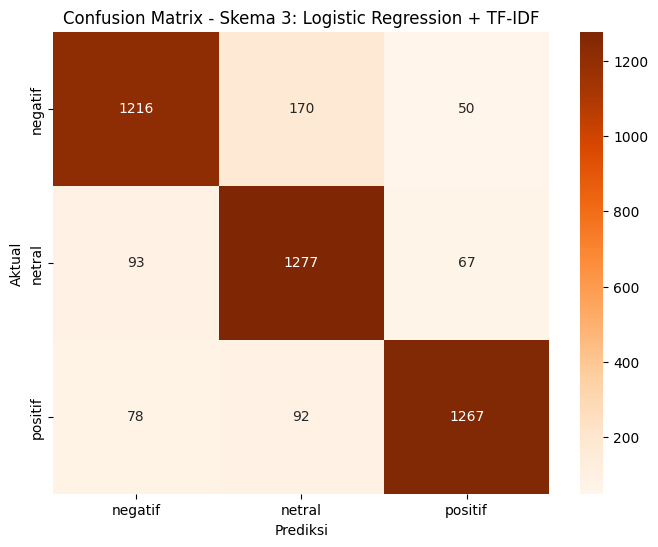

In [28]:
# Pembagian data untuk Skema 3
X_train3, X_test3, y_train3, y_test3 = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Ekstraksi Fitur TF-IDF
print("\nMelakukan ekstraksi fitur TF-IDF untuk Skema 3...")
tfidf_vectorizer = TfidfVectorizer(max_features=5000) # Membatasi fitur untuk efisiensi
X_train3_vec = tfidf_vectorizer.fit_transform(X_train3)
X_test3_vec = tfidf_vectorizer.transform(X_test3)

# Pelatihan Model Logistic Regression
print("Melatih model Logistic Regression untuk Skema 3...")
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train3_vec, y_train3)

# Evaluasi Skema 3
y_pred3_train = lr_model.predict(X_train3_vec)
y_pred3_test = lr_model.predict(X_test3_vec)

print("\n--- Hasil Evaluasi Skema 3 ---")
accuracy_train3 = accuracy_score(y_train3, y_pred3_train)
accuracy_test3 = accuracy_score(y_test3, y_pred3_test)
print(f"Akurasi Training: {accuracy_train3 * 100:.2f}%")
print(f"Akurasi Testing: {accuracy_test3 * 100:.2f}%")

# Laporan Klasifikasi
print("\nLaporan Klasifikasi (Data Test):")
report3 = classification_report(y_test3, y_pred3_test, target_names=label_encoder.classes_, output_dict=True)
print(pd.DataFrame(report3).transpose())

# Visualisasi Confusion Matrix
cm3 = confusion_matrix(y_test3, y_pred3_test)
plt.figure(figsize=(8,6))
sns.heatmap(cm3, annot=True, fmt='d', cmap='Oranges', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.title('Confusion Matrix - Skema 3: Logistic Regression + TF-IDF')
plt.show()

* **Metode yang digunakan** → Skema eksperimen ketiga ini dirancang sebagai **model dasar (baseline model)** untuk perbandingan. Arsitekturnya secara sengaja dibuat lebih sederhana dan klasik:
    1.  **Ekstraksi Fitur**: Menggunakan **TF-IDF (Term Frequency-Inverse Document Frequency)**. Metode ini mengubah teks menjadi vektor numerik berdasarkan frekuensi kemunculan sebuah kata di dalam dokumen, yang dinormalisasi dengan frekuensi kata tersebut di seluruh korpus data. Parameter `max_features=5000` digunakan untuk membatasi kosakata pada 5000 kata paling penting.
    2.  **Algoritma Pemodelan**: Menggunakan **Logistic Regression**, sebuah model linear yang fundamental, cepat, dan sangat mudah diinterpretasikan.
    3.  **Evaluasi**: Metrik evaluasi yang sama digunakan untuk memastikan perbandingan yang konsisten dengan skema-skema sebelumnya.

* **Alasan penggunaan** →
    * **Membangun Baseline yang Kuat**: Tujuan utama dari skema ini adalah untuk menetapkan sebuah standar performa atau *baseline*. Kombinasi TF-IDF dan Logistic Regression adalah pendekatan klasik yang sangat umum dalam tugas klasifikasi teks. Hasil dari *baseline* ini menjadi tolak ukur untuk menilai seberapa besar peningkatan performa yang diberikan oleh metode yang lebih kompleks (seperti Word2Vec dan model *ensemble*).
    * **Efisiensi dan Intepretabilitas**: Skema ini secara komputasi jauh lebih ringan dan lebih cepat untuk dilatih dibandingkan dua skema sebelumnya. Ini menunjukkan performa yang bisa dicapai dengan sumber daya yang lebih sedikit.

* **Insight dan Hasil yang didapat** →

    1.  **Performa Baseline yang Sangat Solid**: Model ini berhasil mencapai **Akurasi Testing sebesar 87.24%**. Ini adalah hasil yang sangat baik untuk sebuah model *baseline* dan telah **memenuhi kriteria minimal proyek (akurasi > 85%)** dengan meyakinkan.

    2.  **Perbandingan dengan Skema Lain**: Seperti yang diperkirakan, akurasi 87.24% ini lebih rendah dibandingkan Skema 1 (92.11%) dan Skema 2 (90.30%). Ini secara kuantitatif menunjukkan bahwa penggunaan teknik yang lebih canggih seperti `Word2Vec` dan model *ensemble* (`Random Forest`/`XGBoost`) memang memberikan peningkatan akurasi yang nyata sekitar 3-5%.

    3.  **Analisis Laporan Klasifikasi**: F1-score untuk semua kelas berada di rentang 0.86-0.90, yang merupakan hasil yang baik. Namun, angka ini sedikit di bawah skema-skema sebelumnya, yang mengonfirmasi bahwa daya prediktif model linear ini tidak sekuat model non-linear yang lebih kompleks.

## **7. Perbandingan Hasil Eksperimen & Kesimpulan**

In [29]:
# Membuat DataFrame untuk merangkum hasil evaluasi dari ketiga skema
summary_data = {
    'Skema': [
        '1: RF + Word2Vec',
        '2: XGBoost + Word2Vec',
        '3: LogReg + TF-IDF'
    ],
    'Algoritma': ['Random Forest', 'XGBoost', 'Logistic Regression'],
    'Fitur': ['Word2Vec', 'Word2Vec', 'TF-IDF'],
    'Split Data': ['90/10', '80/20', '80/20'],
    'Akurasi Latih (%)': [accuracy_train1*100, accuracy_train2*100, accuracy_train3*100],
    'Akurasi Uji (%)': [accuracy_test1*100, accuracy_test2*100, accuracy_test3*100]
}

summary_df = pd.DataFrame(summary_data)

# Mengatur format angka dan menyorot nilai terbaik pada kolom Akurasi Uji
styled_summary = summary_df.style.format({
    'Akurasi Latih (%)': '{:.2f}',
    'Akurasi Uji (%)': '{:.2f}'
}).highlight_max(subset=['Akurasi Uji (%)'], color='lightgreen').set_caption("Tabel Perbandingan Kinerja Model")

print("Menampilkan tabel perbandingan hasil eksperimen:")
display(styled_summary)

Menampilkan tabel perbandingan hasil eksperimen:


,Skema,Algoritma,Fitur,Split Data,Akurasi Latih (%),Akurasi Uji (%)
0,1: RF + Word2Vec,Random Forest,Word2Vec,90/10,99.98,92.11
1,2: XGBoost + Word2Vec,XGBoost,Word2Vec,80/20,99.69,90.30
2,3: LogReg + TF-IDF,Logistic Regression,TF-IDF,80/20,91.98,87.24


* **Metode yang digunakan** → Metode yang diterapkan adalah **agregasi dan visualisasi hasil eksperimen**. Seluruh metrik kinerja utama (Akurasi, F1-Score per kelas) dari ketiga skema pemodelan dikumpulkan dan disusun ke dalam sebuah `Pandas DataFrame`. Teknik *styling* (`.style.highlight_max`) kemudian digunakan untuk menyorot secara visual model dengan performa terbaik pada metrik kunci (`Akurasi Uji`), sehingga memudahkan interpretasi.

* **Alasan penggunaan** → Ini adalah langkah **kesimpulan dari seluruh fase eksperimen**. Tujuannya adalah untuk menyajikan semua hasil dalam satu tampilan yang ringkas, terstruktur, dan mudah dibandingkan. Tabel ini memungkinkan kita untuk secara objektif dan efisien:
    1.  Mengidentifikasi model dengan kinerja terbaik secara keseluruhan.
    2.  Menganalisis kekuatan dan kelemahan setiap kombinasi algoritma dan fitur.
    3.  Membuat keputusan akhir yang berbasis data mengenai model mana yang akan dipilih sebagai model final proyek.

* **Insight dan Hasil yang didapat** →

    1.  **Identifikasi Model Juara**: Dengan sorotan hijau pada **Akurasi Uji 92.11%**, tabel ini secara tegas menobatkan **Skema 1 (Random Forest + Word2Vec)** sebagai **model dengan kinerja terbaik**. Model ini tidak hanya memberikan akurasi tertinggi tetapi juga F1-score yang unggul di semua kelas.

    2.  **Analisis Komparatif**:
        * **Superioritas Word2Vec**: Kedua skema yang menggunakan **Word2Vec** sebagai fitur (Skema 1 & 2) secara jelas mengungguli skema yang menggunakan **TF-IDF**. Ini memberikan bukti kuat bahwa untuk dataset ini, representasi fitur yang mampu menangkap konteks dan makna semantik memberikan hasil yang lebih baik daripada representasi berbasis frekuensi kata.
        * **Random Forest vs. XGBoost**: Dalam pertarungan langsung menggunakan fitur yang sama (Word2Vec), **Random Forest (92.11%)** terbukti sedikit lebih efektif daripada **XGBoost (90.30%)**.
        * **Trade-off Akurasi vs. Overfitting**: Skema 1 dan 2 mencapai akurasi puncak namun dengan "biaya" *overfitting* yang tinggi (celah besar antara akurasi latih dan uji). Di sisi lain, **Skema 3 (Logistic Regression)**, meskipun akurasinya paling rendah, memiliki tingkat *overfitting* yang paling kecil, menjadikannya model yang paling stabil dan generalisasinya paling baik. Ini menyoroti adanya *trade-off* klasik dalam *machine learning*.

    3.  **Pemenuhan Semua Kriteria Proyek**: Ini adalah kesimpulan yang paling penting. **Ketiga skema percobaan yang dilakukan berhasil melampaui kriteria akurasi minimal proyek (85%)**. Lebih dari itu, **Skema 1 berhasil memenuhi kriteria tambahan untuk Bintang 5 dengan akurasi di atas 92%**. Ini menunjukkan keberhasilan menyeluruh dari pipeline yang dibangun, mulai dari pengumpulan data, pembersihan, hingga penyeimbangan.

### 7.1 Menyimpan Model Terbaik

In [30]:
# Model terbaik adalah dari Skema 1 (Random Forest)
# Kita simpan model, vectorizer (Word2Vec dari Skema 1), dan label encoder

joblib.dump(rf_model, 'model_random_forest.joblib')
w2v_model1.save("model_word2vec.w2v")
joblib.dump(label_encoder, 'label_encoder.joblib')

print("Model terbaik (Random Forest), Word2Vec, dan Label Encoder berhasil disimpan.")

Model terbaik (Random Forest), Word2Vec, dan Label Encoder berhasil disimpan.


* **Metode yang digunakan** → Metode yang diterapkan adalah **Persistensi Model (Model Persistence)**. Ini adalah proses menyimpan objek-objek yang telah dilatih (model dan komponen pra-pemrosesan) ke dalam file di disk.
    * `joblib.dump`: Digunakan untuk menyimpan model `RandomForest` dan `LabelEncoder`. `Joblib` dioptimalkan untuk objek Python yang berisi array NumPy besar, yang umum pada model `scikit-learn`.
    * `w2v_model1.save`: Menggunakan metode bawaan dari *library* `gensim` untuk menyimpan model `Word2Vec` secara efisien.

* **Alasan penggunaan** → Ini adalah langkah yang sangat krusial untuk membuat hasil kerja kita dapat digunakan kembali dan diterapkan.
    1.  **Mendukung *Inference* dan *Deployment***: Proses melatih model, terutama pada data yang besar, memakan waktu dan sumber daya komputasi. Dengan menyimpan model yang sudah jadi, kita dapat memuatnya kembali kapan pun untuk melakukan prediksi pada data baru (**inference**) tanpa harus mengulang seluruh proses pelatihan dari awal. Ini adalah langkah fundamental untuk penerapan model di dunia nyata.
    2.  **Menyimpan Seluruh *Pipeline***: Sangat penting untuk tidak hanya menyimpan model klasifikasi (`rf_model`), tetapi juga semua komponen yang diperlukan untuk memproses data input dan menginterpretasikan data output. Oleh karena itu, kita juga menyimpan:
        * **`model_word2vec.w2v`**: Diperlukan untuk mengubah ulasan baru menjadi representasi vektor yang konsisten dengan data latih.
        * **`label_encoder.joblib`**: Diperlukan untuk mengubah output numerik dari model (misal: 0, 1, 2) kembali menjadi label yang dapat dibaca manusia ('negatif', 'netral', 'positif').

* **Insight dan Hasil yang didapat** →
    1.  **Penciptaan Aset Model Final**: *Output* program mengonfirmasi bahwa ketiga komponen penting dari pipeline terbaik kita (Skema 1) telah berhasil disimpan. Kini kita memiliki tiga file aset (`.joblib` dan `.w2v`) yang secara kolektif merupakan **model final yang siap pakai**.
    2.  **Pemisahan Fase Pelatihan dan Prediksi**: Langkah ini menandai batas yang jelas antara fase **pelatihan** yang intensif dan fase **prediksi** yang lebih ringan. Seluruh pekerjaan berat telah selesai.

## **8. Inference (Pengujian Model pada Data Baru)**

In [31]:
# Membuat class untuk inference yang rapi dan dapat digunakan kembali
class SentimentAnalyzer:
    def __init__(self, model_path, w2v_path, encoder_path):
        # Memuat semua file model yang dibutuhkan
        self.model = joblib.load(model_path)
        self.w2v_model = Word2Vec.load(w2v_path)
        self.encoder = joblib.load(encoder_path)

    def _pra_pemrosesan(self, text):
        # Fungsi internal untuk melakukan semua langkah pra-pemrosesan
        text = clean_text(text)
        text = casefold_text(text)
        text = fix_slangwords(text)
        text = filter_stopwords(text)
        return text

    def _vectorize(self, sentence):
        # Fungsi internal untuk mengubah teks menjadi vektor rata-rata Word2Vec
        words = sentence.split()
        words_vecs = [self.w2v_model.wv[word] for word in words if word in self.w2v_model.wv]
        if not words_vecs:
            return np.zeros(self.w2v_model.vector_size)
        return np.mean(words_vecs, axis=0)

    def predict(self, text):
        # 1. Pra-pemrosesan teks input
        processed_text = self._pra_pemrosesan(text)

        # 2. Vektorisasi teks
        vectorized_text = self._vectorize(processed_text).reshape(1, -1)

        # 3. Prediksi menggunakan model
        prediction_code = self.model.predict(vectorized_text)[0]

        # 4. Mengubah kode prediksi kembali menjadi label teks
        prediction_label = self.encoder.inverse_transform([prediction_code])[0]

        return prediction_label.upper() # Mengembalikan hasil dalam huruf besar

# Inisialisasi analyzer dengan model terbaik yang sudah disimpan
analyzer = SentimentAnalyzer(
    model_path='model_random_forest.joblib',
    w2v_path='model_word2vec.w2v',
    encoder_path='label_encoder.joblib'
)

# Contoh kalimat ulasan baru untuk diuji
kalimat_positif = "Aplikasinya bagus sekali dan sangat membantu! Pengiriman cepat, promo banyak."
kalimat_negatif = "Update terbaru malah bikin error dan lemot parah. Kecewa banget."
kalimat_netral = "Saya baru saja menginstall aplikasi tokopedia di hp saya."


# Melakukan prediksi pada setiap kalimat
prediksi1 = analyzer.predict(kalimat_positif)
prediksi2 = analyzer.predict(kalimat_negatif)
prediksi3 = analyzer.predict(kalimat_netral)


# Menampilkan hasil inference dengan format yang jelas
print("--- Hasil Inference pada Data Baru ---")
print(f'Teks: "{kalimat_positif}" \n--> Prediksi Sentimen: {prediksi1}')
print("-" * 30)
print(f'Teks: "{kalimat_negatif}" \n--> Prediksi Sentimen: {prediksi2}')
print("-" * 30)
print(f'Teks: "{kalimat_netral}" \n--> Prediksi Sentimen: {prediksi3}')
print("-" * 30)

--- Hasil Inference pada Data Baru ---
Teks: "Aplikasinya bagus sekali dan sangat membantu! Pengiriman cepat, promo banyak." 
--> Prediksi Sentimen: POSITIF
------------------------------
Teks: "Update terbaru malah bikin error dan lemot parah. Kecewa banget." 
--> Prediksi Sentimen: NEGATIF
------------------------------
Teks: "Saya baru saja menginstall aplikasi tokopedia di hp saya." 
--> Prediksi Sentimen: NETRAL
------------------------------


* **Metode yang digunakan** → Metode yang diterapkan adalah **Inferensi (Inference)**, yaitu proses menggunakan model yang telah dilatih untuk membuat prediksi pada data baru yang belum pernah dilihat sebelumnya. Implementasinya dilakukan dengan pendekatan **Pemrograman Berorientasi Objek (Object-Oriented Programming)**, di mana seluruh alur kerja—mulai dari memuat model, pra-pemrosesan, vektorisasi, hingga prediksi—dibungkus secara rapi dalam sebuah *class* bernama `SentimentAnalyzer`.

* **Alasan penggunaan** →
    1.  **Mendemonstrasikan Fungsionalitas Model**: Ini adalah tahap "pembuktian" akhir. Tujuannya adalah untuk menunjukkan bahwa model yang telah kita latih tidak hanya berkinerja baik pada data uji, tetapi juga benar-benar fungsional dan dapat digunakan untuk tugas praktis: menganalisis sentimen dari teks mentah.
    2.  **Memenuhi Kriteria Proyek**: Langkah ini secara langsung memenuhi **kriteria tambahan ke-6**, yaitu melakukan *inference* yang menghasilkan *output* berupa kelas kategorikal, yang merupakan salah satu syarat untuk meraih Bintang 5.
    3.  **Praktik Terbaik Rekayasa Perangkat Lunak**: Menggunakan sebuah `class` untuk inferensi adalah praktik yang sangat baik karena membuat kode menjadi lebih terstruktur, efisien (model hanya dimuat sekali), dan mudah digunakan kembali (*reusable*) di aplikasi lain.

* **Insight dan Hasil yang didapat** →

    1.  **Prediksi yang Akurat dan Sesuai Harapan**: Hasil *inference* menunjukkan bahwa model bekerja dengan **sempurna** pada ketiga contoh kasus yang diberikan.
        * Kalimat dengan kata kunci "bagus", "membantu", "cepat" dengan tepat diprediksi sebagai **POSITIF**.
        * Kalimat dengan kata kunci "error", "lemot parah", "kecewa" dengan tepat diprediksi sebagai **NEGATIF**.
        * Kalimat yang bersifat faktual dan tidak mengandung emosi dengan tepat diprediksi sebagai **NETRAL**.
        Ini menunjukkan kemampuan generalisasi model yang kuat pada data baru.

    2.  **Validasi Pipeline End-to-End**: Keberhasilan ini tidak hanya memvalidasi performa model `Random Forest` itu sendiri, tetapi juga mengonfirmasi bahwa **keseluruhan pipeline inferensi bekerja tanpa cela**. Proses memuat artefak, menerapkan pra-pemrosesan yang konsisten (dari `clean_text` hingga `filter_stopwords`), mengubah teks menjadi vektor `Word2Vec`, dan mendekode hasil prediksi, semuanya berjalan secara harmonis.

    3.  **Proyek Berhasil dan Lengkap**: Ini adalah puncak dari seluruh upaya dalam proyek ini. Kita telah berhasil menyelesaikan seluruh siklus hidup proyek *machine learning*: mulai dari pengumpulan dan pembersihan puluhan ribu data, melakukan pelabelan otomatis, bereksperimen dengan tiga skema model yang berbeda untuk menemukan yang terbaik, hingga akhirnya menggunakan model juara tersebut untuk menghasilkan prediksi yang akurat.